# Summary on using VAEs to compress gLV data

Author: Zhengqing Zhou
Updated: 2025/06/13

In this notebook, we recall the models trained on each individual dataset with different latent dimensions, and quantify the essential dimensionality for reconstructing n_target population dynamics

In [ ]:
# We begin by importing the essentials
import numpy as np
import matplotlib.pyplot as plt

# We also setup torch for later usage.
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import trange
from torch.nn import functional as F
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import pickle

# Configure GPU if available
if torch.cuda.is_available():

    device = "cuda:0"
else:
    device = "cpu"

display(device)

## Visualize the target dynamics

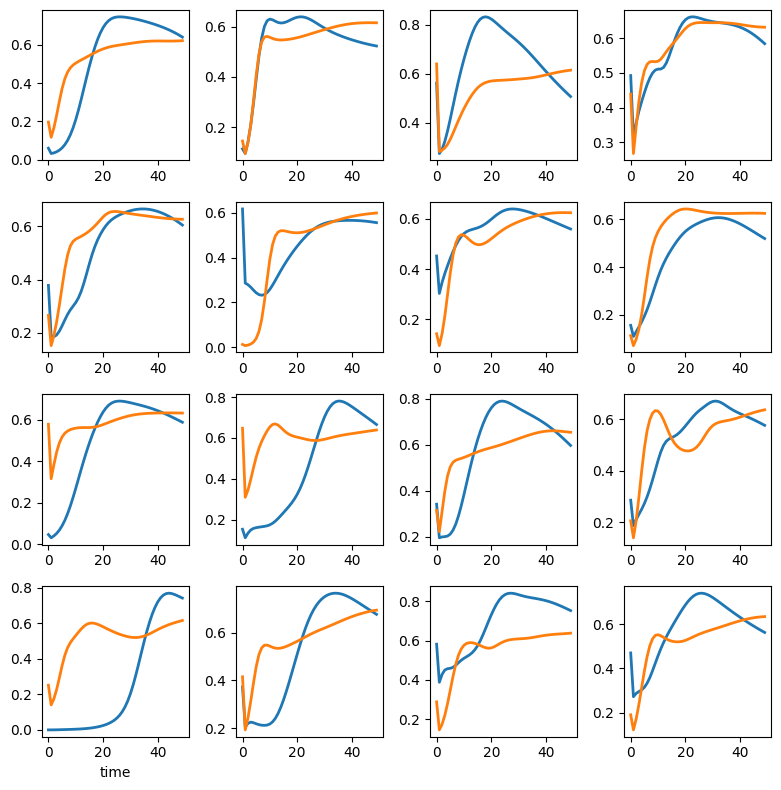

In [4]:
n_ori = 100
n_target = 2
n_background = n_ori-n_target
glv_type = "b"
sim_type = "random"
model_index = 1
X_test = np.load("./saved_sims/%sgLV/I%i/%sgLV_B%i_T%i_%s_test.npy"
                           % (glv_type, model_index, glv_type, n_background, n_target, sim_type, ))
fig,axes=plt.subplots(4,4,figsize=(8,8))
axes=axes.flat
for i,ax in enumerate(axes):
    y_target = X_test[i]
    for j in range(n_target):
        ax.plot(y_target[j,:],lw=2)
ax=axes[12]
ax.set_xlabel("time")
fig.tight_layout()
        

## VAE Network
The VAE network has 32 channels in the encoder, consisting of 3 convolutional layers, each followed by a leaky relu function, with kernel = 3, strid = 1, and padding = 1, so the time series (length of 50) will not get shortened during the convolutions; 1 fully connected linear layer; and another two parallel linear layers to project the encoded time series to the mean value and var of the latent dimension, based on which a gaussian sampling will be done, generating the embedding of the data. The embedding is further decoded by a decoder of the symmetrical structure.

In [5]:
class VAE(nn.Module):

    def __init__(self, n_target, latent_dim):
        # Call parent model constructor and store hidden state variables.
        super().__init__()
        self.latent_dim = latent_dim
        self.n_target = n_target
        self.T = 50
        self.channels = 32

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=self.n_target, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
        )

        self.mean_map = nn.Linear(self.channels * self.T, self.latent_dim)

        self.std_map = nn.Linear(self.channels * self.T, self.latent_dim)

        self.fc_decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.channels * self.T),
            nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1,
                               padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1,
                               padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(in_channels=self.channels, out_channels=self.n_target, kernel_size=3, stride=1,
                               padding=1),
            nn.LeakyReLU()
        )

    def sample(self, mean, log_var):
        """Sample a given N(0,1) normal distribution given a mean and log of variance."""

        # First compute the variance from the log variance.
        var = torch.exp(0.5 * log_var)

        # Compute a scaled distribution
        eps = torch.randn_like(var)

        # Add the vectors
        z = mean + var * eps

        return z

    def forward(self, X):
        """Forward propogate through the model, return both the reconstruction and sampled mean and standard deviation
        for the system.
        """
        pre_code = self.encoder(X)
        B, C, L = pre_code.shape
        flattened = pre_code.view(B, C * L)

        mu = self.mean_map(flattened)
        log_var = self.std_map(flattened)

        code = self.sample(mu, log_var)

        # Pass through FC layers before decoding
        post_code = self.fc_decoder(code)

        X_hat = self.decoder(post_code.view(B, C, L))

        return X_hat, code, mu, log_var


def vae_loss(x_hat, x, mu, log_var):
    "Compute the sum of BCE and KL loss for the distribution."

    # weight for the KL divergence
    alpha = 1e-4

    # Compute the reconstruction loss
    BCE = F.mse_loss(x_hat, x)

    # Compute the KL divergence of the distribution.
    KLD = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

    return BCE + alpha * KLD

## VAE Network (complex)
We also define a VAE network (VAE4) that's more complex than the VAE model above. This network is used to embed the time series of bounded gLV model with stronger interactions, and dispersal gLV model.

This VAE network has 64 channels in the encoder, consisting of 4 convolutional layers, each followed by a leaky relu function, with kernel = 3, strid = 1, and padding = 1, so the time series (length of 50) will not get shortened during the convolutions; 1 fully connected linear layer; and another two parallel linear layers to project the encoded time series to the mean value and var of the latent dimension, based on which a gaussian sampling will be done, generating the embedding of the data. The embedding is further decoded by a decoder of the symmetrical structure.

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
def get_data(n_background, n_target, glv_type, sim_type, model_index):
    X_train = np.load("./saved_sims/%sgLV/I%i/%sgLV_B%i_T%i_%s_train.npy"
                               % (glv_type, model_index, glv_type, n_background, n_target, sim_type, ))
    X_test = np.load("./saved_sims/%sgLV/I%i/%sgLV_B%i_T%i_%s_test.npy"
                               % (glv_type, model_index, glv_type, n_background, n_target, sim_type, ))

    return X_train, X_test

In [12]:
def get_error(model,batch,):
    model.to("cuda:0");
    model.eval()
    with torch.no_grad():
        reconstruction,_,mu,log_var = model(batch.to("cuda:0"))
        reconstruction = reconstruction.cpu()
        mse = F.mse_loss(batch,reconstruction)
        r2 = r2_score(batch.flatten(), reconstruction.flatten())
        kld = (-0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp()))
    return mse,kld,r2

# A training example

In [8]:
def train_model(model, data_loader, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for batch in data_loader:
        batch = batch.to("cuda:0")
        optimizer.zero_grad()
        pred, code, mu, log_var = model(batch)
        loss = vae_loss(pred, batch, mu, log_var)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

def test_model(model, data_loader):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to("cuda:0")
            pred, code, mu, log_var = model(batch)
            loss = vae_loss(pred, batch, mu, log_var)
            total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

In [9]:
def run(n_background,n_target,n_embedding,X_train,X_test,glv_type,sim_type,model_index,trial=2):
    # set the random seed so the three trials have different initial model weights
    seed = 1000 * n_target + 10*n_embedding + trial
    torch.manual_seed(seed)
    
    lr = 1e-3
    batch_size = 64
    EPOCHS = 100
    
    X_train = torch.Tensor(X_train).float()
    X_test = torch.Tensor(X_test).float()
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=False)

    model = VAE(n_target, n_embedding)
    model.to("cuda:0");
    model.train()
    train_losses = []
    test_losses = []
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for ix_epoch in trange(EPOCHS):
        train_err = train_model(model, train_loader, optimizer)
        test_err = test_model(model, test_loader)
        train_losses.append(train_err)
        test_losses.append(test_err)

    print("training finished, with starting MSE %1.1e, and ending error %1.1e" % (test_losses[0], test_losses[-1]))
    return model,train_losses, test_losses

In [10]:
n_ori = 100
n_target = 2
n_background = n_ori-n_target

glv_type = "b"
sim_type = "random"
model_index = 1

n_embedding = 2

X_train, X_test = get_data(n_background, n_target, glv_type = glv_type, sim_type = sim_type, model_index = model_index)
model, train_loss, test_loss = run(n_background,n_target,n_embedding,X_train,X_test,glv_type,sim_type,model_index)

  0%|          | 0/100 [00:00<?, ?it/s]

training finished, with starting MSE 7.5e-03, and ending error 3.2e-03


model parameters: 2.4e+04
2-target, 2-embedding; MSE: 2.97e-03, KLD: 2.72e+00, r2:0.895


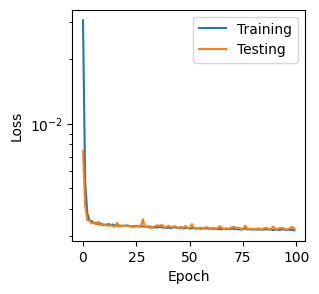

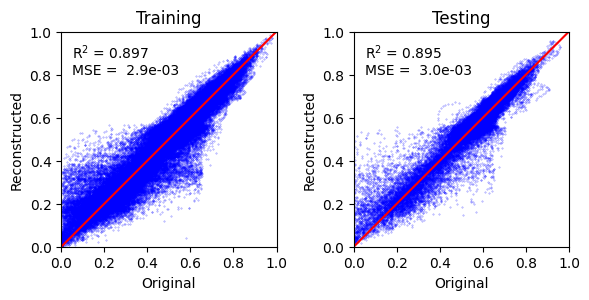

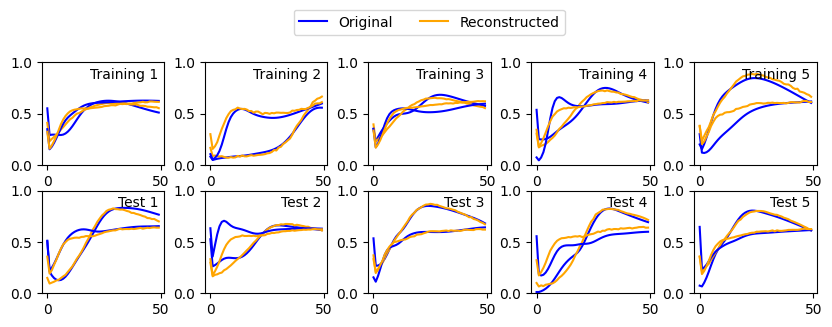

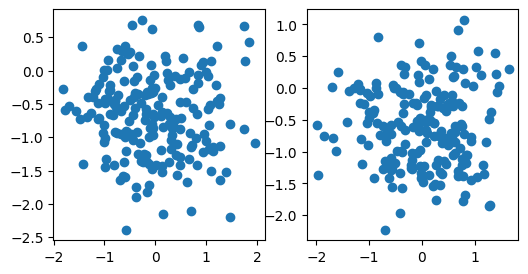

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset

print(f"model parameters: {count_parameters(model):.1e}")
mse_test,kld,r2_test=get_error(model,torch.Tensor(X_test))
print(f"{n_target}-target, {n_embedding}-embedding; MSE: {mse_test:.2e}, KLD: {kld:.2e}, r2:{r2_test:.3f}")
# Plotting the loss values
plt.figure(figsize=(3, 3))
plt.semilogy(train_loss, label='Training')
plt.semilogy(test_loss, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#rank both train and test data for visualization
train_data=torch.Tensor(X_train)
sums = train_data.var(dim=(1,2))  # Shape: (B,)
ranked_indices_train = torch.argsort(sums,descending=True)  # Sort by total sum


test_data=torch.Tensor(X_test)
sums = test_data.var(dim=(1,2))  # Shape: (B,)
ranked_indices_test = torch.argsort(sums,descending=True)  # Sort by total sum


with torch.no_grad():
    output_train, code_train, _, _ = model(train_data.to(device))
    output_test, code_test, _, _ = model(test_data.to(device))

# Squeeze the output to match the original data dimension
train_data = train_data
test_data = test_data
output_train = output_train
output_test = output_test

output_train = output_train.cpu().numpy()
output_test = output_test.cpu().numpy()

# Percentage of data to visualize
percentage = 0.2
num_train_samples = int(len(train_data) * percentage)
num_test_samples = int(len(test_data) * percentage)

# Index into the data tensors
subset_train_data = train_data[:num_train_samples]
subset_test_data = test_data[:num_test_samples]

subset_train_pred = output_train[:num_train_samples]
subset_test_pred = output_test[:num_test_samples]

# Plotting the reconstructed data against the original data
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

# Training data plot
axs[0].scatter(subset_train_data.flatten(), subset_train_pred.flatten(), s=0.1, color='blue', alpha=0.5)
axs[0].plot([0,1], [0,1], 'r')  # y=x line
axs[0].set_xlim([0,1])
axs[0].set_ylim([0,1])
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('Original')
axs[0].set_ylabel('Reconstructed')
axs[0].set_title('Training')

r2_train = r2_score(train_data.flatten(), output_train.flatten())
mse_train = np.square(train_data-output_train).mean()
axs[0].text(0.05, 0.95, f'R$^2$ = {r2_train:.3f}\nMSE = {mse_train: .1e}', transform=axs[0].transAxes, verticalalignment='top')

# Testing data plot
axs[1].scatter(subset_test_data.flatten(), subset_test_pred.flatten(), s=0.1, color='blue', alpha=0.5)
axs[1].plot([0,1], [0,1], 'r')  # y=x line
axs[1].set_xlim([0,1])
axs[1].set_ylim([0,1])
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlabel('Original')
axs[1].set_ylabel('Reconstructed')
axs[1].set_title('Testing')

r2_test = r2_score(test_data.flatten(), output_test.flatten())
mse_test = np.square(test_data-output_test).mean()
axs[1].text(0.05, 0.95, f'R$^2$ = {r2_test:.3f}\nMSE = {mse_test: .1e}', transform=axs[1].transAxes, verticalalignment='top')

plt.tight_layout()

# Additional Panels for Sample Data Trajectories
fig, axs = plt.subplots(2, 5, figsize=(10, 3))

# Training data trajectories
idx_show = np.random.choice(np.arange(train_data.shape[0]),5,replace=False)
for i,idx in enumerate(idx_show):
    for j in range(n_target):
        axs[0, i].plot(train_data[idx,j], color='blue')
        axs[0, i].plot(output_train[idx,j], color='orange')
    axs[0, i].text(x=0.95,y=0.95,s=f'Training {i + 1}',ha="right",va="top",transform=axs[0,i].transAxes)
    axs[0, i].set_ylim([0,1])
axs[0,2].plot([], label='Original', color='blue')
axs[0,2].plot([], label='Reconstructed', color='orange')
axs[0,2].legend(loc="lower center",bbox_to_anchor=(0.5,1.2),ncol=2)
# Testing data trajectories
idx_show = np.random.choice(np.arange(test_data.shape[0]),5,replace=False)
for i,idx in enumerate(idx_show):
    for j in range(n_target):
        axs[1, i].plot(test_data[idx,j], color='blue')
        axs[1, i].plot(output_test[idx,j], color='orange')
    axs[1, i].text(x=0.95,y=0.95,s=f'Test {i + 1}',ha="right",va="top",transform=axs[1,i].transAxes)
    axs[1, i].set_ylim([0,1])

plt.subplots_adjust(hspace=0.25,wspace=0.33)
plt.show()

fig,axes=plt.subplots(1,2,figsize=(6,3))
ax1,ax2=axes
code_train = code_train.cpu()
code_test = code_test.cpu()
ax1.scatter(code_train[0:200,0],code_train[0:200,1])
ax2.scatter(code_test[0:200,0],code_test[0:200,1])

# Visualize the reconstruction of a given trained model

R2: 0.90, mse: 2.90e-03


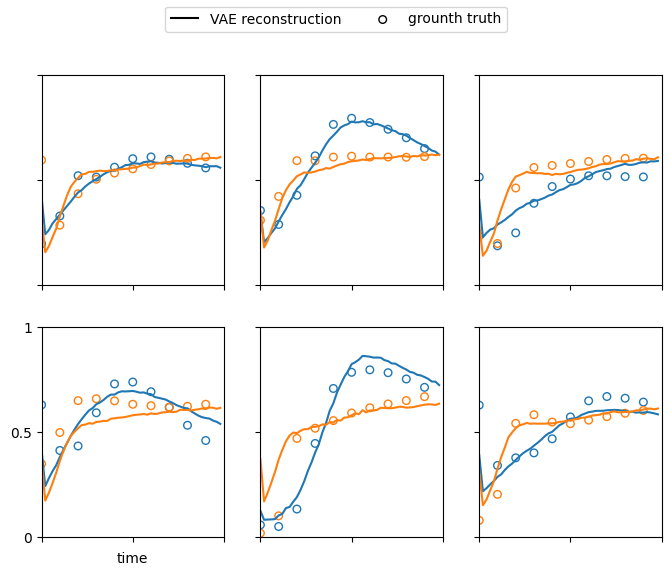

In [14]:
glv_type="b"
sim_type="random"
model_index=1
n_ori=100
n_target=2
n_background=n_ori-n_target
trial=1
x=np.arange(0,50,1)
n_embedding = 2

X_train, X_test = get_data(n_background, n_target, glv_type, sim_type, model_index)

batch=torch.Tensor(X_train).float()
n_show=6
tp_show=np.arange(0,50,5)
fig,axes=plt.subplots(2,3,figsize=(8,6))
axes=axes.flat

model = VAE(n_target,n_embedding)
model.to("cuda:0");
model.load_state_dict(
    torch.load(
        "./vae_models/%sgLV/I%i/%s_B%i_T%i_E%i_trial%i.pth"
        % (glv_type, model_index, sim_type, n_background, n_target, n_embedding, trial),weights_only=True)
)
model.eval()

loss=0
with torch.no_grad():
    pred, code, mu, log_var = model(batch.to(device))
    pred=pred.cpu()
    loss=F.mse_loss(batch,pred).item()
r2 = r2_score(batch.flatten(),pred.flatten())
print(f"R2: {r2:.2f}, mse: {loss:.2e}")
np.random.seed(42)
idx_show = np.random.choice(np.arange(batch.shape[0]),n_show,replace=False)
for i,ii in enumerate(idx_show):
    ax=axes[i]
    data=batch[ii]
    rec=pred[ii]
    for k in range(n_target):
        l=ax.plot(x,rec[k,:],linewidth=1.5)
        ax.scatter(x[tp_show],data[k,tp_show],s=30,edgecolor=l[-1].get_color(),facecolor="None")
        ax.set_xlim([0,50])
        ax.set_xticks([0,25,50])
        ax.set_xticklabels([])
        ax.set_yticks([0,0.5,1])
        ax.set_yticklabels([])
    ax.set_ylim([0,1])
ax=axes[3]
ax.set_xticklabels([])
ax.set_xlabel("time")
ax.set_yticklabels([0,0.5,1])
ax.plot([],[],c="k",linewidth=1.5,label="VAE reconstruction")
ax.scatter([],[],s=30,edgecolor="k",facecolor="None",label="grounth truth")
fig.legend(loc="upper center",ncol=2)

# Effective dimension of observable dynamics within a 100-member microbiome

**to calculate the FUV, code below this point requires downloading the entire dataset from Zenodo; but statistical analysis can be performed with `saved_data` folder.**

We define a function *get_error* which will return the MSE loss of the reconstruction of a *n_background*, *n_target* population (simulated with *gLV_type* dynamic model) using an *n_embedding* dimensional VAE model. By iterating through all the parameters, we can then determine the essential dimensionality for the reconstruction of a given size target population dynamics.


In [ ]:
def get_error(model,batch,):
    model.to("cuda:0");
    model.eval()
    with torch.no_grad():
        reconstruction,_,mu,log_var = model(batch.to("cuda:0"))
        reconstruction = reconstruction.cpu()
        mse = F.mse_loss(batch,reconstruction)
        r2 = r2_score(batch.flatten(), reconstruction.flatten())
        kld = (-0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp()))
    return mse,kld,r2

## Bounded gLV

### Fixed background case
Call the trained models to determine the MSE, KL divergence, and the R2 of each embedding

In [ ]:
n_ori=100

glv_type="b"
sim_type="fixed"

NT=np.arange(2,11,1)
N_EBD = [1,2,3,5,6,8,10,12,15,20]
for i,n_target in enumerate(NT):
    n_background=n_ori-n_target
    for model_index in [1,2,3]:
        data_train = np.zeros((6,len(N_EBD)))
        data_train[0,:] = N_EBD
        data_test = np.zeros((6,len(N_EBD)))
        data_test[0,:] = N_EBD
        X_train, X_test = get_data(n_background, n_target, glv_type, sim_type, model_index)
        batch_train = torch.Tensor(X_train).float()
        batch_test = torch.Tensor(X_test).float()
        for trial in range(1,6,1):
            for j,n_embedding in enumerate(N_EBD):
                model = VAE(n_target,n_embedding)
                model.to("cuda:0");
                model.load_state_dict(
                    torch.load(
                        "./vae_models/%sgLV/I%i/%s_B%i_T%i_E%i_trial%i.pth"
                        % (glv_type, model_index, sim_type, n_background, n_target, n_embedding, trial),weights_only=True)
                )
                mse_train,kld,r2_train=get_error(model,batch_train)
                data_train[trial,j]=(1-r2_train)*100
                mse_test,kld,r2_test=get_error(model,batch_test)
                data_test[trial,j]=(1-r2_test)*100
        np.savetxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_train.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type),data_train)
        np.savetxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_test.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type),data_test)
        print("model %i; target %i finished"%(model_index,n_target,))

In [ ]:
NT=np.arange(2,11,1)
n_ori=100
n_trial = 5
glv_type="b"
sim_type="fixed"
model_index=3
fig,axes=plt.subplots(2,3,figsize=(8,4))
axes=axes.flat
for i,n_target in enumerate(NT):
    ax=axes[i]
    n_background = n_ori-n_target
    data_train=np.loadtxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_train.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type))
    data_test=np.loadtxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_test.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type))
    N_EBD = data_train[0,:]
    for j,data in enumerate([data_train,data_test]):
        FUV = data[1:,:]
        mean_FUV = np.mean(FUV,axis=0)
        std_FUV = np.std(FUV,axis=0,ddof=1)
        se_FUV = std_FUV/np.sqrt(n_trial)
        mfc = 'white' if j==0 else 'steelblue'
        ax.scatter(N_EBD,mean_FUV,facecolor=mfc,edgecolor='steelblue')
        ax.errorbar(N_EBD,mean_FUV,yerr=se_FUV,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
        ax.plot(N_EBD,mean_FUV,c='steelblue')
ax=axes[0]
ax.scatter([],[],facecolor='white',edgecolor='steelblue',label='train')
ax.scatter([],[],facecolor='steelblue',edgecolor='steelblue',label='test')
ax.legend()
ax=axes[3]
ax.set_xlabel("n$_{embedding}$")
ax.set_ylabel("FUV%")
axes[-1].set_visible(False)

Now fit the FUV-embedding relationship to an exponential threshold function

In [12]:
from scipy.optimize import curve_fit

def y_exp(x,a,b,c):
    yy = -b*(x-a)
    yy[x>a]=0
    y = c*np.exp(yy)
    return y

[2.56963217 2.06561189 0.05575294]
[3.50156524 1.40605261 0.09261008]
[4.97270319 0.89449718 0.14453536]
[5.65786066 0.79696793 0.16352751]
[7.50804514 0.61941665 0.1529062 ]
[8.99356409 0.47838362 0.20670915]
[8.80324586 0.45400764 0.30800289]
[11.08024276  0.35395754  0.30393583]
[11.960621    0.28972673  0.18921761]


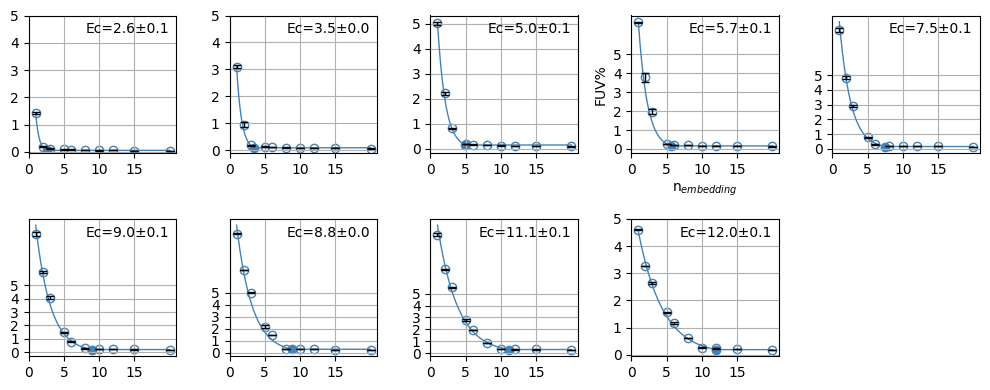

In [18]:
NT=np.arange(2,11,1)
n_ori=100
n_trial = 5
glv_type="b"
sim_type="fixed"
model_index=3
fig,axes=plt.subplots(2,5,figsize=(10,4))
axes=axes.flat
Ec_data = np.zeros((3,len(NT)))
Ec_data[0,:]=NT
for i,n_target in enumerate(NT):
    ax=axes[i]
    n_background = n_ori-n_target
    data=np.loadtxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_test.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type))
    N_EBD=data[0,:]
    FUV = data[1:,:]
    mean_FUV = np.mean(FUV,axis=0)
    std_FUV = np.std(FUV,axis=0,ddof=1)
    se_FUV = std_FUV/np.sqrt(n_trial)
    ax.scatter(N_EBD,mean_FUV,fc='white',ec='steelblue')
    ax.errorbar(N_EBD,mean_FUV,yerr=se_FUV,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
    
    popt, pcov = curve_fit(y_exp, N_EBD, mean_FUV, sigma=se_FUV, absolute_sigma=True, p0=(n_target, 0.5, 0.5))
    print(popt)
    Ec = popt[0]
    param_errors = np.sqrt(np.diag(pcov))# estimate the standard errors of the fitted parameters
    Ec_se = param_errors[0]
    Ec_data[1,i]=Ec
    Ec_data[2,i]=Ec_se
    y_Ec = y_exp(np.array([Ec]),*popt)
    ax.scatter(Ec,y_Ec,c='steelblue')
    xx=np.linspace(1,20,1000)
    yy=y_exp(xx,*popt)
    ax.plot(xx,yy,color="steelblue",linewidth=1)
    
    ax.text(x=0.95,y=0.95,s="Ec=%1.1f±%1.1f"%(Ec,Ec_se),ha="right",va="top",transform=ax.transAxes)
    if i==3:
        ax.set_xlabel("n$_{embedding}$")
        ax.set_ylabel("FUV%")
    ax.set_xticks(np.arange(0,20,5))
    ax.set_yticks(np.arange(6))
    ax.grid(True)
axes[-1].set_visible(False)
fig.tight_layout()
np.savetxt(f"./saved_data/{glv_type}gLV/Ec_{glv_type}gLV_model{model_index}_{sim_type}.txt",Ec_data)

fixed bgLV Community 1
Slope            : 1.157 ± 0.006 (SE)
Intercept        : 0.132 ± 0.037 (SE)
t-statistic      : 179.77  (dof = 7)
p-value (slope≠0): 4.35e-14
Weighted R²      : 0.996
fixed bgLV Community 2
Slope            : 1.120 ± 0.006 (SE)
Intercept        : 0.420 ± 0.034 (SE)
t-statistic      : 180.78  (dof = 7)
p-value (slope≠0): 4.17e-14
Weighted R²      : 0.986
fixed bgLV Community 3
Slope            : 1.151 ± 0.008 (SE)
Intercept        : 0.148 ± 0.053 (SE)
t-statistic      : 136.50  (dof = 7)
p-value (slope≠0): 2.99e-13
Weighted R²      : 0.979


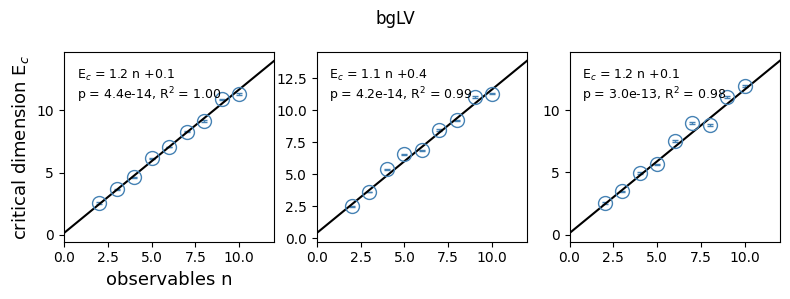

In [3]:
from scipy.optimize import curve_fit
from scipy.stats import t

# Linear model
def linear_model(x, a, b):
    return a * x + b

glv_type="b"
sim_type="fixed"
fig,axes = plt.subplots(1,3,figsize=(8,3))
axes=axes.flat
for i,model_index in enumerate([1,2,3]):
    ax=axes[i]
    data = np.loadtxt(f"./saved_data/{glv_type}gLV/Ec_{glv_type}gLV_model{model_index}_{sim_type}.txt")
    # Extract x, y, and CI bounds
    N_TG = data[0,:]
    Ec = data[1,:]
    Ec_se = data[2,:]
    ax.errorbar(N_TG,Ec,Ec_se,marker="o",c='steelblue',mfc="None",capsize=2,lw=0,markersize=10,
                    elinewidth=1)
    
    # Weighted fit using standard errors
    popt, pcov = curve_fit(linear_model, N_TG, Ec, sigma=Ec_se, absolute_sigma=True)
    slope, intercept = popt
    slope_se, intercept_se = np.sqrt(np.diag(pcov))

    # residuals and total sums of squares
    y_pred = linear_model(N_TG, slope, intercept)
    SS_res = np.sum(((Ec - y_pred)/Ec_se)**2)     # weighted residual SS
    SS_tot = np.sum(((Ec - np.average(Ec, weights=1/Ec_se**2))/Ec_se)**2)
    
    R2 = 1 - SS_res / SS_tot
    
    # Compute t-statistic and p-value
    dof = len(N_TG) - 2
    t_stat = slope / slope_se
    p_value = 2 * (1 - t.cdf(np.abs(t_stat), df=dof))
    
    # Generate fit line and CI band
    x_fit = np.linspace(0, 12, 100)
    y_fit = linear_model(x_fit, slope, intercept)

    ax.plot(x_fit,y_fit,c="k")
    ax.set_xlim([0, 12])
    
    # ----- formatted report ---------------------------------------------------
    print(f"{sim_type} {glv_type}gLV Community {model_index}")
    report = (
        f"Slope            : {slope:.3f} ± {slope_se:.3f} (SE)\n"
        f"Intercept        : {intercept:.3f} ± {intercept_se:.3f} (SE)\n"
        f"t-statistic      : {t_stat:.2f}  (dof = {dof})\n"
        f"p-value (slope≠0): {p_value:.3g}\n"
        f"Weighted R²      : {R2:.3f}"
    )

    print(report)

    # Format regression equation
    txt = (f"E$_c$ = {slope:.1f} n {intercept:+.1f}\n"
       f"p = {p_value:.1e}, R$^2$ = {R2:.2f}")
    ax.text(x=0.06, y=0.75, s=txt, transform=ax.transAxes, fontsize=9)
    #ax.text(x=0.11,y=0.85,s=txt,transform=ax.transAxes, fontsize=10)
ax=axes[0]
ax.set_xlabel("observables n", fontsize=13)
ax.set_ylabel("critical dimension E$_c$", fontsize=13)
fig.suptitle(f"{glv_type}gLV")
fig.tight_layout()

### Random Background Case

In [ ]:
n_ori=100

glv_type="b"
sim_type="random"

NT=np.arange(1,11,1)
N_EBD = [1, 2, 3, 5, 6, 8, 10, 12, 15, 20, 25, 30, 40, 50] # for n_target <= 5
N_EBD = [1, 2, 3, 5, 6, 8, 10, 12, 15, 20, 25, 30, 35, 40, 50] # for n_target >= 5
for i,n_target in enumerate(NT):
    n_background=n_ori-n_target
    for model_index in [1,2,3]:
        data_train = np.zeros((6,len(N_EBD)))
        data_train[0,:] = N_EBD
        data_test = np.zeros((6,len(N_EBD)))
        data_test[0,:] = N_EBD
        X_train, X_test = get_data(n_background, n_target, glv_type, sim_type, model_index)
        batch_train = torch.Tensor(X_train).float()
        batch_test = torch.Tensor(X_test).float()
        for trial in range(1,6,1):
            for j,n_embedding in enumerate(N_EBD):
                model = VAE(n_target,n_embedding)
                model.to("cuda:0");
                model.load_state_dict(
                    torch.load(
                        "./vae_models/%sgLV/I%i/%s_B%i_T%i_E%i_trial%i.pth"
                        % (glv_type, model_index, sim_type, n_background, n_target, n_embedding, trial),weights_only=True)
                )
                mse_train,kld,r2_train=get_error(model,batch_train)
                data_train[trial,j]=(1-r2_train)*100
                mse_test,kld,r2_test=get_error(model,batch_test)
                data_test[trial,j]=(1-r2_test)*100
        np.savetxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_train.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type),data_train)
        np.savetxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_test.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type),data_test)
        print("model %i; target %i finished"%(model_index,n_target,))

Text(0, 0.5, 'FUV%')

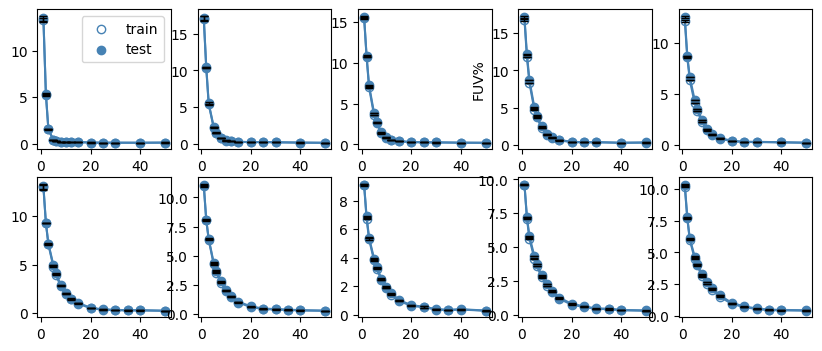

In [59]:
NT=np.arange(1,11,1)
n_ori=100
n_trial = 5
glv_type="b"
sim_type="random"
model_index=1
fig,axes=plt.subplots(2,5,figsize=(10,4))
axes=axes.flat
for i,n_target in enumerate(NT):
    ax=axes[i]
    n_background = n_ori-n_target
    data_train=np.loadtxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_train.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type))
    data_test=np.loadtxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_test.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type))
    N_EBD = data_train[0,:]
    for j,data in enumerate([data_train,data_test]):
        FUV = data[1:,:]
        mean_FUV = np.mean(FUV,axis=0)
        std_FUV = np.std(FUV,axis=0,ddof=1)
        se_FUV = std_FUV/np.sqrt(n_trial)
        mfc = 'white' if j==0 else 'steelblue'
        ax.scatter(N_EBD,mean_FUV,facecolor=mfc,edgecolor='steelblue')
        ax.errorbar(N_EBD,mean_FUV,yerr=se_FUV,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
        ax.plot(N_EBD,mean_FUV,c='steelblue')
ax=axes[0]
ax.scatter([],[],facecolor='white',edgecolor='steelblue',label='train')
ax.scatter([],[],facecolor='steelblue',edgecolor='steelblue',label='test')
ax.legend()
ax=axes[3]
ax.set_xlabel("n$_{embedding}$")
ax.set_ylabel("FUV%")

In [60]:
from scipy.optimize import curve_fit

def y_exp(x,a,b,c):
    yy = -b*(x-a)
    yy[x>a]=0
    y = c*np.exp(yy)
    return y

[8.83274581 0.46226834 0.11055439]
[9.06903827 0.48353362 0.34208752]
[12.90789907  0.32944856  0.29085678]
[15.33678555  0.2692353   0.32961607]
[17.12641746  0.21770259  0.32165598]
[20.9469164   0.17582746  0.31554117]
[19.58366858  0.16500263  0.43350888]
[19.56586675  0.16437522  0.37795714]
[21.27764132  0.14520729  0.43051769]
[22.13493057  0.12058636  0.6232203 ]


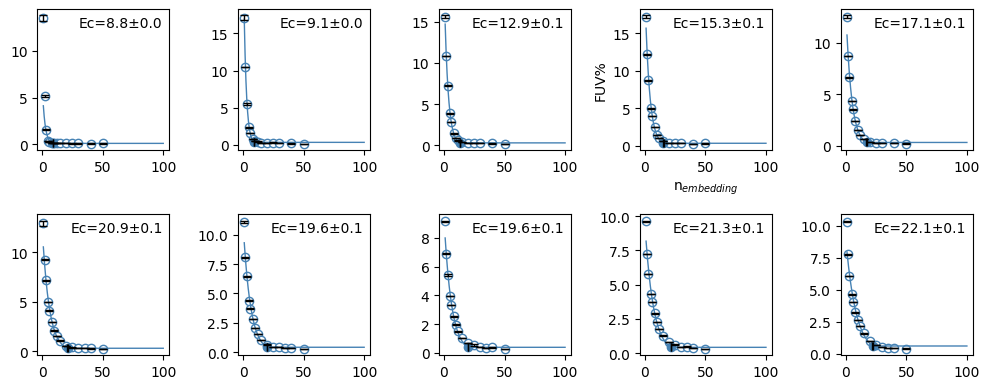

In [63]:
NT=np.arange(1,11,1)
n_ori=100
n_trial = 5
glv_type="b"
sim_type="random"
model_index=1
fig,axes=plt.subplots(2,5,figsize=(10,4))
axes=axes.flat
Ec_data = np.zeros((3,len(NT)))
Ec_data[0,:]=NT
for i,n_target in enumerate(NT):
    ax=axes[i]
    n_background = n_ori-n_target
    data=np.loadtxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_test.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type))
    N_EBD=data[0,:]
    FUV = data[1:,:]
    mean_FUV = np.mean(FUV,axis=0)
    std_FUV = np.std(FUV,axis=0,ddof=1)
    se_FUV = std_FUV/np.sqrt(n_trial)
    ax.scatter(N_EBD,mean_FUV,fc='white',ec='steelblue')
    ax.errorbar(N_EBD,mean_FUV,yerr=se_FUV,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
    
    popt, pcov = curve_fit(y_exp, N_EBD, mean_FUV, sigma=se_FUV, absolute_sigma=True, 
                           p0=(10+n_target, 0.2, 0.2))
    print(popt)
    Ec = popt[0]
    param_errors = np.sqrt(np.diag(pcov))# estimate the standard errors of the fitted parameters
    Ec_se = param_errors[0]
    Ec_data[1,i]=Ec
    Ec_data[2,i]=Ec_se
    y_Ec = y_exp(np.array([Ec]),*popt)
    ax.scatter(Ec,y_Ec,c='steelblue')
    ax.errorbar(Ec,y_Ec,xerr=Ec_se,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
    xx=np.linspace(1,100,1000)
    yy=y_exp(xx,*popt)
    ax.plot(xx,yy,color="steelblue",linewidth=1)
    
    ax.text(x=0.95,y=0.95,s="Ec=%1.1f±%1.1f"%(Ec,Ec_se),ha="right",va="top",transform=ax.transAxes)
    if i==3:
        ax.set_xlabel("n$_{embedding}$")
        ax.set_ylabel("FUV%")
fig.tight_layout()
np.savetxt(f"./saved_data/{glv_type}gLV/Ec_{glv_type}gLV_model{model_index}_{sim_type}.txt",Ec_data)

random bgLV Community 1
Slope            : 1.725 ± 0.006 (SE)
Intercept        : 7.050 ± 0.032 (SE)
t-statistic      : 265.58  (dof = 8)
p-value (slope≠0): 0
Weighted R²      : 0.925
random bgLV Community 2
Slope            : 1.667 ± 0.006 (SE)
Intercept        : 8.564 ± 0.033 (SE)
t-statistic      : 268.14  (dof = 8)
p-value (slope≠0): 0
Weighted R²      : 0.971
random bgLV Community 3
Slope            : 2.180 ± 0.006 (SE)
Intercept        : 6.338 ± 0.029 (SE)
t-statistic      : 342.55  (dof = 8)
p-value (slope≠0): 0
Weighted R²      : 0.912


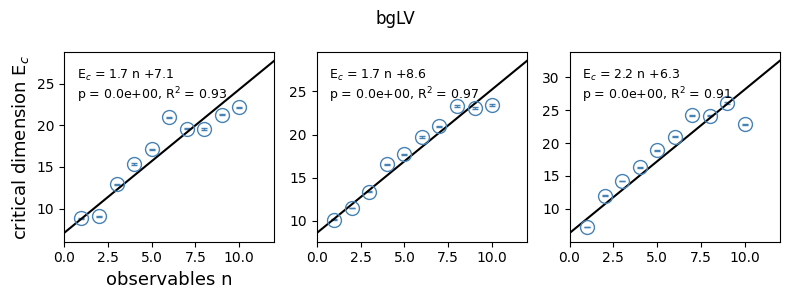

In [4]:
from scipy.optimize import curve_fit
from scipy.stats import t

# Linear model
def linear_model(x, a, b):
    return a * x + b

glv_type="b"
sim_type="random"
fig,axes = plt.subplots(1,3,figsize=(8,3))
axes=axes.flat
for i,model_index in enumerate([1,2,3]):
    ax=axes[i]
    data = np.loadtxt(f"./saved_data/{glv_type}gLV/Ec_{glv_type}gLV_model{model_index}_{sim_type}.txt")
    # Extract x, y, and CI bounds
    N_TG = data[0,:]
    Ec = data[1,:]
    Ec_se = data[2,:]
    ax.errorbar(N_TG,Ec,Ec_se,marker="o",c='steelblue',mfc="None",capsize=2,lw=0,markersize=10,
                    elinewidth=1)
    
    # Weighted fit using standard errors
    popt, pcov = curve_fit(linear_model, N_TG, Ec, sigma=Ec_se, absolute_sigma=True)
    slope, intercept = popt
    slope_se, intercept_se = np.sqrt(np.diag(pcov))
    
    # Compute t-statistic and p-value
    dof = len(N_TG) - 2
    t_stat = slope / slope_se
    p_value = 2 * (1 - t.cdf(np.abs(t_stat), df=dof))

    # residuals and total sums of squares
    y_pred = linear_model(N_TG, slope, intercept)
    SS_res = np.sum(((Ec - y_pred)/Ec_se)**2)     # weighted residual SS
    SS_tot = np.sum(((Ec - np.average(Ec, weights=1/Ec_se**2))/Ec_se)**2)
    
    R2 = 1 - SS_res / SS_tot
    
    # Generate fit line and CI band
    x_fit = np.linspace(0, 12, 100)
    y_fit = linear_model(x_fit, slope, intercept)

    ax.plot(x_fit,y_fit,c="k")
    ax.set_xlim([0, 12])
    
    # ----- formatted report ---------------------------------------------------
    print(f"{sim_type} {glv_type}gLV Community {model_index}")
    report = (
        f"Slope            : {slope:.3f} ± {slope_se:.3f} (SE)\n"
        f"Intercept        : {intercept:.3f} ± {intercept_se:.3f} (SE)\n"
        f"t-statistic      : {t_stat:.2f}  (dof = {dof})\n"
        f"p-value (slope≠0): {p_value:.3g}\n"
        f"Weighted R²      : {R2:.3f}"
    )

    print(report)


    # Format regression equation
    txt = (f"E$_c$ = {slope:.1f} n {intercept:+.1f}\n"
       f"p = {p_value:.1e}, R$^2$ = {R2:.2f}")
    ax.text(x=0.06, y=0.75, s=txt, transform=ax.transAxes, fontsize=9)
    #ax.text(x=0.11,y=0.85,s=txt,transform=ax.transAxes, fontsize=10)
ax=axes[0]
ax.set_xlabel("observables n", fontsize=13)
ax.set_ylabel("critical dimension E$_c$", fontsize=13)
fig.suptitle(f"{glv_type}gLV")
fig.tight_layout()

In [65]:
glv_type="b"
sim_type="random"
model_index=3
data = np.loadtxt(f"./saved_data/{glv_type}gLV/Ec_{glv_type}gLV_model{model_index}_{sim_type}.txt")
N_TG = data[0,:]
Ec = data[1,:]
for k in range(len(N_TG)):
    n_target=N_TG[k]
    print(f"{int(n_target)}-target Ec = {Ec[k]:.1f}, round up to {int(np.ceil(Ec[k]))}")

1-target Ec = 7.2, round up to 8
2-target Ec = 12.0, round up to 13
3-target Ec = 14.2, round up to 15
4-target Ec = 16.3, round up to 17
5-target Ec = 18.9, round up to 19
6-target Ec = 20.9, round up to 21
7-target Ec = 24.2, round up to 25
8-target Ec = 24.2, round up to 25
9-target Ec = 26.1, round up to 27
10-target Ec = 22.9, round up to 23


In [84]:
glv_type="b"
sim_type="random"
model_index=3
data = np.loadtxt(f"./saved_data/{glv_type}gLV/Ec_{glv_type}gLV_model{model_index}_{sim_type}.txt")
N_TG = data[0,:]
Ec = data[1,:]
for k in range(len(N_TG)):
    n_target=N_TG[k]
    print(f"{int(n_target)}-target Ec = {Ec[k]:.1f}, round up to {int(np.ceil(Ec[k]))}")

2-target Ec = 12.0, round up to 13
3-target Ec = 14.2, round up to 15
5-target Ec = 18.9, round up to 19
8-target Ec = 24.2, round up to 25
10-target Ec = 22.5, round up to 23


### Examine the change in Ec for smaller communities

Model index 4 - 6 corresponds to the 10-member community simulations

In [ ]:
n_ori=10

glv_type="b"
sim_type="random"


NT=np.arange(1,11,1)
N_EBD=[1,2,3,5,6,8,10,12,15,20,25,30]

for i,n_target in enumerate(NT):
    n_background=n_ori-n_target
    for model_index in [4,5,6]:
        data_train = np.zeros((6,len(N_EBD)))
        data_train[0,:] = N_EBD
        data_test = np.zeros((6,len(N_EBD)))
        data_test[0,:] = N_EBD
        X_train, X_test = get_data(n_background, n_target, glv_type, sim_type, model_index)
        batch_train = torch.Tensor(X_train).float()
        batch_test = torch.Tensor(X_test).float()
        for trial in range(1,6,1):
            for j,n_embedding in enumerate(N_EBD):
                model = VAE(n_target,n_embedding)
                model.to("cuda:0");
                model.load_state_dict(
                    torch.load(
                        "./vae_models/%sgLV/I%i/%s_B%i_T%i_E%i_trial%i.pth"
                        % (glv_type, model_index, sim_type, n_background, n_target, n_embedding, trial),weights_only=True)
                )
                mse_train,kld,r2_train=get_error(model,batch_train)
                data_train[trial,j]=(1-r2_train)*100
                mse_test,kld,r2_test=get_error(model,batch_test)
                data_test[trial,j]=(1-r2_test)*100
        np.savetxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_train.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type),data_train)
        np.savetxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_test.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type),data_test)
        print("model %i; target %i finished"%(model_index,n_target,))

In [8]:
from scipy.optimize import curve_fit

def y_exp(x,a,b,c):
    yy = -b*(x-a)
    yy[x>a]=0
    y = c*np.exp(yy)
    return y

[3.43154447 1.08838853 0.44321141]
[4.97861059 0.90486698 0.12978731]
[7.38360651 0.50963532 0.2097479 ]
[7.25409876 0.51366904 0.38574099]
[7.85519046 0.51066576 0.33414101]
[8.91197245 0.43430575 0.45864451]
[8.8223418  0.44364445 0.53333907]
[10.19854219  0.41614627  0.40159923]
[10.46101099  0.37059684  0.59193233]
[12.2437249   0.34791885  0.4138107 ]


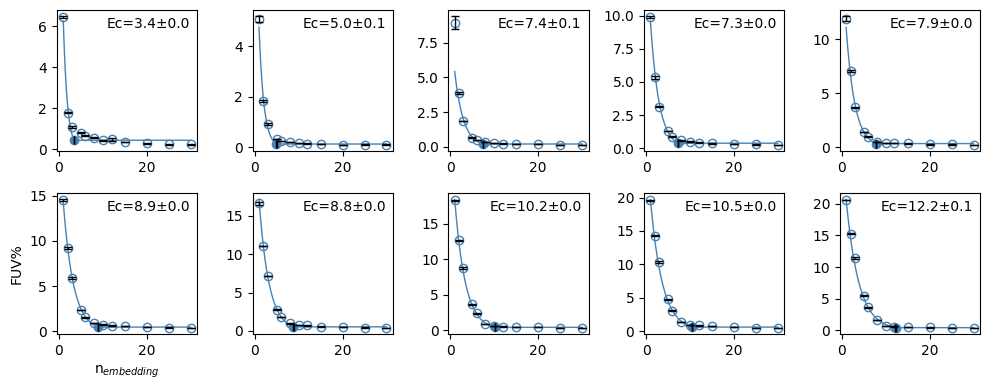

In [24]:
NT=np.arange(1,11,1)
n_ori=10
n_trial = 5
glv_type="b"
sim_type="random"
model_index=6
fig,axes=plt.subplots(2,5,figsize=(10,4))
axes=axes.flat
Ec_data = np.zeros((3,len(NT)))
Ec_data[0,:]=NT
for i,n_target in enumerate(NT):
    ax=axes[i]
    n_background = n_ori-n_target
    data=np.loadtxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_test.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type))
    N_EBD=data[0,:]
    FUV = data[1:,:]
    mean_FUV = np.mean(FUV,axis=0)
    std_FUV = np.std(FUV,axis=0,ddof=1)
    se_FUV = std_FUV/np.sqrt(n_trial)
    ax.scatter(N_EBD,mean_FUV,fc='white',ec='steelblue')
    ax.errorbar(N_EBD,mean_FUV,yerr=se_FUV,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
    
    popt, pcov = curve_fit(y_exp, N_EBD, mean_FUV, sigma=se_FUV, absolute_sigma=True, 
                           p0=(n_target, 0.5, 0.5))
    print(popt)
    Ec = popt[0]
    param_errors = np.sqrt(np.diag(pcov))# estimate the standard errors of the fitted parameters
    Ec_se = param_errors[0]
    Ec_data[1,i]=Ec
    Ec_data[2,i]=Ec_se
    y_Ec = y_exp(np.array([Ec]),*popt)
    ax.scatter(Ec,y_Ec,c='steelblue')
    ax.errorbar(Ec,y_Ec,xerr=Ec_se,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
    xx=np.linspace(1,30,1000)
    yy=y_exp(xx,*popt)
    ax.plot(xx,yy,color="steelblue",linewidth=1)
    
    ax.text(x=0.95,y=0.95,s="Ec=%1.1f±%1.1f"%(Ec,Ec_se),ha="right",va="top",transform=ax.transAxes)
    if i==5:
        ax.set_xlabel("n$_{embedding}$")
        ax.set_ylabel("FUV%")
fig.tight_layout()
np.savetxt(f"./saved_data/{glv_type}gLV/Ec_{glv_type}gLV_model{model_index}_{sim_type}.txt",Ec_data)

random bgLV Community 4
Slope            : 0.706 ± 0.006 (SE)
Intercept        : 3.637 ± 0.032 (SE)
t-statistic      : 125.42  (dof = 8)
p-value (slope≠0): 1.82e-14
Weighted R²      : 0.883
random bgLV Community 5
Slope            : 0.807 ± 0.005 (SE)
Intercept        : 3.671 ± 0.030 (SE)
t-statistic      : 154.42  (dof = 8)
p-value (slope≠0): 3.33e-15
Weighted R²      : 0.968
random bgLV Community 6
Slope            : 0.871 ± 0.005 (SE)
Intercept        : 3.213 ± 0.028 (SE)
t-statistic      : 184.40  (dof = 8)
p-value (slope≠0): 8.88e-16
Weighted R²      : 0.944


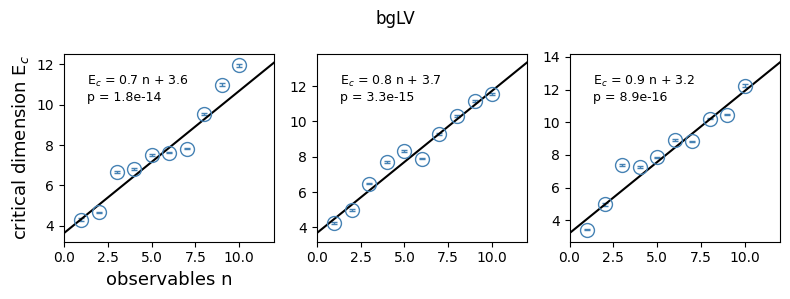

In [17]:
from scipy.optimize import curve_fit
from scipy.stats import t

# Linear model
def linear_model(x, a, b):
    return a * x + b

glv_type="b"
sim_type="random"
fig,axes = plt.subplots(1,3,figsize=(8,3))
axes=axes.flat
for i,model_index in enumerate([4,5,6]):
    ax=axes[i]
    data = np.loadtxt(f"./saved_data/{glv_type}gLV/Ec_{glv_type}gLV_model{model_index}_{sim_type}.txt")
    # Extract x, y, and CI bounds
    N_TG = data[0,:]
    Ec = data[1,:]
    Ec_se = data[2,:]
    ax.errorbar(N_TG,Ec,Ec_se,marker="o",c='steelblue',mfc="None",capsize=2,lw=0,markersize=10,
                    elinewidth=1)
    
    # Weighted fit using standard errors
    popt, pcov = curve_fit(linear_model, N_TG, Ec, sigma=Ec_se, absolute_sigma=True)
    slope, intercept = popt
    slope_se, intercept_se = np.sqrt(np.diag(pcov))
    
    # Compute t-statistic and p-value
    dof = len(N_TG) - 2
    t_stat = slope / slope_se
    p_value = 2 * (1 - t.cdf(np.abs(t_stat), df=dof))
    # residuals and total sums of squares
    y_pred = linear_model(N_TG, slope, intercept)
    SS_res = np.sum(((Ec - y_pred)/Ec_se)**2)     # weighted residual SS
    SS_tot = np.sum(((Ec - np.average(Ec, weights=1/Ec_se**2))/Ec_se)**2)
    
    R2 = 1 - SS_res / SS_tot
    
    # Generate fit line and CI band
    x_fit = np.linspace(0, 12, 100)
    y_fit = linear_model(x_fit, slope, intercept)

    ax.plot(x_fit,y_fit,c="k")
    ax.set_xlim([0, 12])
    
    # ----- formatted report ---------------------------------------------------
    print(f"{sim_type} {glv_type}gLV Community {model_index}")
    report = (
        f"Slope            : {slope:.3f} ± {slope_se:.3f} (SE)\n"
        f"Intercept        : {intercept:.3f} ± {intercept_se:.3f} (SE)\n"
        f"t-statistic      : {t_stat:.2f}  (dof = {dof})\n"
        f"p-value (slope≠0): {p_value:.3g}\n"
        f"Weighted R²      : {R2:.3f}"
    )

    print(report)
    
    # Format regression equation
    txt = f"E$_c$ = {slope:.1f} n {'+' if intercept >= 0 else '-'} {abs(intercept):.1f}\np = {p_value:.1e}"
    ax.text(x=0.11, y=0.75, s=txt, transform=ax.transAxes, fontsize=9)
    #ax.text(x=0.11,y=0.85,s=txt,transform=ax.transAxes, fontsize=10)
ax=axes[0]
ax.set_xlabel("observables n", fontsize=13)
ax.set_ylabel("critical dimension E$_c$", fontsize=13)
fig.suptitle(f"{glv_type}gLV")
fig.tight_layout()

In [16]:
glv_type="b"
sim_type="random"
model_index=6
data = np.loadtxt(f"./saved_data/{glv_type}gLV/Ec_{glv_type}gLV_model{model_index}_{sim_type}.txt")
N_TG = data[0,:]
Ec = data[1,:]
for k in range(len(N_TG)):
    n_target=N_TG[k]
    print(f"{int(n_target)}-target Ec = {Ec[k]:.1f}, round up to {int(np.ceil(Ec[k]))}")

1-target Ec = 3.4, round up to 4
2-target Ec = 5.0, round up to 5
3-target Ec = 7.4, round up to 8
4-target Ec = 7.3, round up to 8
5-target Ec = 7.9, round up to 8
6-target Ec = 8.9, round up to 9
7-target Ec = 8.8, round up to 9
8-target Ec = 10.2, round up to 11
9-target Ec = 10.5, round up to 11
10-target Ec = 12.2, round up to 13


In [14]:
glv_type="b"
sim_type="random"
model_index=4
data = np.loadtxt(f"./saved_data/{glv_type}gLV/Ec_{glv_type}gLV_model{model_index}_{sim_type}.txt")
N_TG = data[0,:]
Ec = data[1,:]
for k in range(len(N_TG)):
    n_target=N_TG[k]
    print(f"{int(n_target)}-target Ec = {Ec[k]:.1f}, round up to {int(np.ceil(Ec[k]))}")

2-target Ec = 4.6, round up to 5
3-target Ec = 6.8, round up to 7
5-target Ec = 7.6, round up to 8
8-target Ec = 9.6, round up to 10
10-target Ec = 11.8, round up to 12


### Communities with stronger interactions
We next look at communities with stronger positive and negative interactions. 
$$
-0.8 \leq \gamma \leq -0.4, \quad 0.4 \leq \alpha \leq 0.8
$$

In [ ]:
n_ori=100

glv_type="b"
sim_type="random"

NT=np.arange(1,11,1)
N_EBD = [1, 2, 3, 5, 6, 8, 10, 12, 15, 20, 25, 30, 35, 40, 50, 60, 80, 100]

for i,n_target in enumerate(NT):
    n_background=n_ori-n_target
    for model_index in [7,8,9]:
        data_train = np.zeros((6,len(N_EBD)))
        data_train[0,:] = N_EBD
        data_test = np.zeros((6,len(N_EBD)))
        data_test[0,:] = N_EBD
        X_train, X_test = get_data(n_background, n_target, glv_type, sim_type, model_index)
        batch_train = torch.Tensor(X_train).float()
        batch_test = torch.Tensor(X_test).float()
        for trial in range(1,6,1):
            for j,n_embedding in enumerate(N_EBD):
                model = VAE4(n_target,n_embedding)
                model.to("cuda:0");
                model.load_state_dict(
                    torch.load(
                        "./vae_models/%sgLV/I%i/%s_B%i_T%i_E%i_trial%i.pth"
                        % (glv_type, model_index, sim_type, n_background, n_target, n_embedding, trial),weights_only=True)
                )
                mse_train,kld,r2_train=get_error(model,batch_train)
                data_train[trial,j]=(1-r2_train)*100
                mse_test,kld,r2_test=get_error(model,batch_test)
                data_test[trial,j]=(1-r2_test)*100
        np.savetxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_train.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type),data_train)
        np.savetxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_test.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type),data_test)
        print("model %i; target %i finished"%(model_index,n_target,))

Text(0, 0.5, 'FUV%')

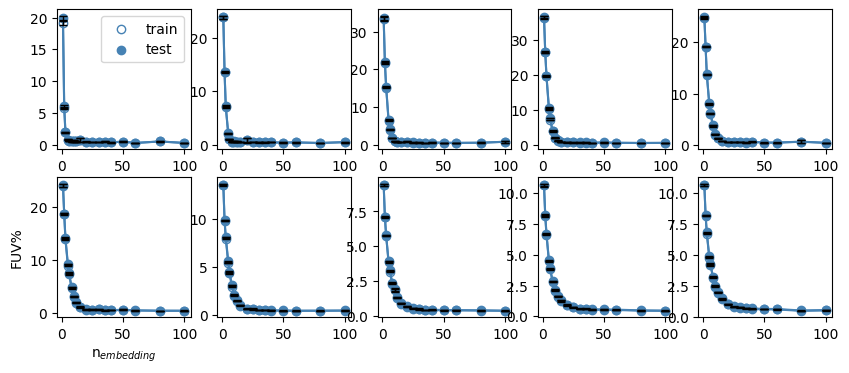

In [3]:
NT=np.arange(1,11,1)
n_ori=100
n_trial = 5
glv_type="b"
sim_type="random"
model_index=8
fig,axes=plt.subplots(2,5,figsize=(10,4))
axes=axes.flat
for i,n_target in enumerate(NT):
    ax=axes[i]
    n_background = n_ori-n_target
    data_train=np.loadtxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_train.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type))
    data_test=np.loadtxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_test.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type))
    N_EBD = data_train[0,:]
    for j,data in enumerate([data_train,data_test]):
        FUV = data[1:,:]
        mean_FUV = np.mean(FUV,axis=0)
        std_FUV = np.std(FUV,axis=0,ddof=1)
        se_FUV = std_FUV/np.sqrt(n_trial)
        mfc = 'white' if j==0 else 'steelblue'
        ax.scatter(N_EBD,mean_FUV,facecolor=mfc,edgecolor='steelblue')
        ax.errorbar(N_EBD,mean_FUV,yerr=se_FUV,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
        ax.plot(N_EBD,mean_FUV,c='steelblue')
ax=axes[0]
ax.scatter([],[],facecolor='white',edgecolor='steelblue',label='train')
ax.scatter([],[],facecolor='steelblue',edgecolor='steelblue',label='test')
ax.legend()
ax=axes[5]
ax.set_xlabel("n$_{embedding}$")
ax.set_ylabel("FUV%")

In [31]:
from scipy.optimize import curve_fit

def y_exp(x,a,b,c):
    yy = -b*(x-a)
    yy[x>a]=0
    y = c*np.exp(yy)
    return y

[3.73170206 1.16323122 0.38668867]
[7.06987939 0.66926624 0.26620937]
[10.48154011  0.42491731  0.32615706]
[13.66815781  0.30987951  0.39631818]
[16.66251051  0.23940448  0.52642344]
[19.29683155  0.19421735  0.63156658]
[19.72612893  0.1726025   0.82297169]
[23.10508426  0.15030425  0.79963897]
[21.46573473  0.14108158  0.90370564]
[19.93970496  0.14560019  1.18153791]


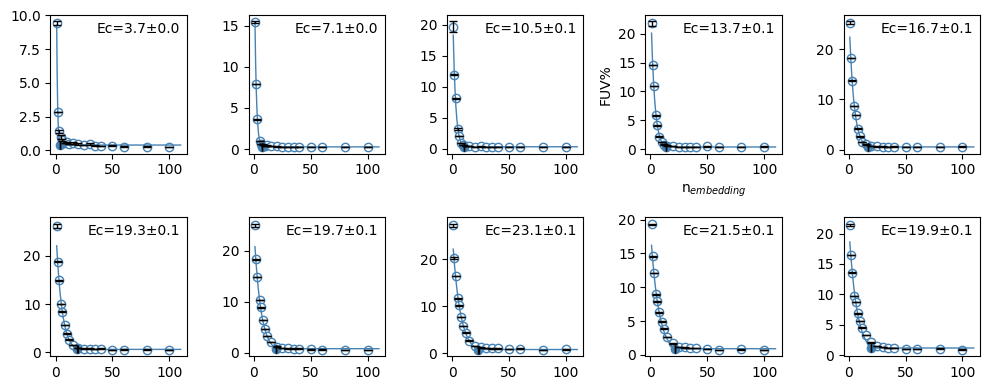

In [35]:
NT=np.arange(1,11,1)
n_ori=100
n_trial = 5
glv_type="b"
sim_type="random"
model_index=9
fig,axes=plt.subplots(2,5,figsize=(10,4))
axes=axes.flat
Ec_data = np.zeros((3,len(NT)))
Ec_data[0,:]=NT
for i,n_target in enumerate(NT):
    ax=axes[i]
    n_background = n_ori-n_target
    data=np.loadtxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_test.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type))
    N_EBD=data[0,:]
    FUV = data[1:,:]
    mean_FUV = np.mean(FUV,axis=0)
    std_FUV = np.std(FUV,axis=0,ddof=1)
    se_FUV = std_FUV/np.sqrt(n_trial)
    ax.scatter(N_EBD,mean_FUV,fc='white',ec='steelblue')
    ax.errorbar(N_EBD,mean_FUV,yerr=se_FUV,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
    
    popt, pcov = curve_fit(y_exp, N_EBD, mean_FUV, sigma=se_FUV, absolute_sigma=True, 
                           p0=(n_target+10, 0.2, 1))
    print(popt)
    Ec = popt[0]
    param_errors = np.sqrt(np.diag(pcov))# estimate the standard errors of the fitted parameters
    Ec_se = param_errors[0]
    Ec_data[1,i]=Ec
    Ec_data[2,i]=Ec_se
    y_Ec = y_exp(np.array([Ec]),*popt)
    ax.scatter(Ec,y_Ec,c='steelblue')
    ax.errorbar(Ec,y_Ec,xerr=Ec_se,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
    xx=np.linspace(1,110,1000)
    yy=y_exp(xx,*popt)
    ax.plot(xx,yy,color="steelblue",linewidth=1)
    
    ax.text(x=0.95,y=0.95,s="Ec=%1.1f±%1.1f"%(Ec,Ec_se),ha="right",va="top",transform=ax.transAxes)
    if i==3:
        ax.set_xlabel("n$_{embedding}$")
        ax.set_ylabel("FUV%")
fig.tight_layout()
np.savetxt(f"./saved_data/{glv_type}gLV/Ec_{glv_type}gLV_model{model_index}_{sim_type}.txt",Ec_data)

random bgLV Community 7
Slope            : 1.855 ± 0.008 (SE)
Intercept        : 5.918 ± 0.042 (SE)
t-statistic      : 219.63  (dof = 8)
p-value (slope≠0): 2.22e-16
Weighted R²      : 0.923
random bgLV Community 8
Slope            : 1.744 ± 0.007 (SE)
Intercept        : 4.515 ± 0.031 (SE)
t-statistic      : 243.24  (dof = 8)
p-value (slope≠0): 2.22e-16
Weighted R²      : 0.875
random bgLV Community 9
Slope            : 2.290 ± 0.008 (SE)
Intercept        : 2.555 ± 0.033 (SE)
t-statistic      : 286.93  (dof = 8)
p-value (slope≠0): 0
Weighted R²      : 0.915


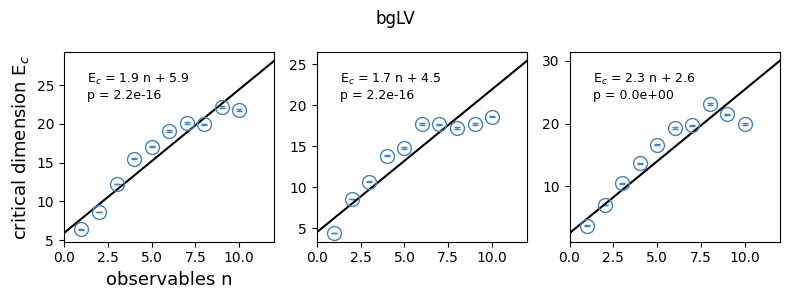

In [37]:
from scipy.optimize import curve_fit
from scipy.stats import t

# Linear model
def linear_model(x, a, b):
    return a * x + b

glv_type="b"
sim_type="random"
fig,axes = plt.subplots(1,3,figsize=(8,3))
axes=axes.flat
for i,model_index in enumerate([7,8,9]):
    ax=axes[i]
    data = np.loadtxt(f"./saved_data/{glv_type}gLV/Ec_{glv_type}gLV_model{model_index}_{sim_type}.txt")
    # Extract x, y, and CI bounds
    N_TG = data[0,:]
    Ec = data[1,:]
    Ec_se = data[2,:]
    ax.errorbar(N_TG,Ec,Ec_se,marker="o",c='steelblue',mfc="None",capsize=2,lw=0,markersize=10,
                    elinewidth=1)
    
    # Weighted fit using standard errors
    popt, pcov = curve_fit(linear_model, N_TG, Ec, sigma=Ec_se, absolute_sigma=True)
    slope, intercept = popt
    slope_se, intercept_se = np.sqrt(np.diag(pcov))
    
    # Compute t-statistic and p-value
    dof = len(N_TG) - 2
    t_stat = slope / slope_se
    p_value = 2 * (1 - t.cdf(np.abs(t_stat), df=dof))
    # residuals and total sums of squares
    y_pred = linear_model(N_TG, slope, intercept)
    SS_res = np.sum(((Ec - y_pred)/Ec_se)**2)     # weighted residual SS
    SS_tot = np.sum(((Ec - np.average(Ec, weights=1/Ec_se**2))/Ec_se)**2)
    
    R2 = 1 - SS_res / SS_tot
    
    # Generate fit line and CI band
    x_fit = np.linspace(0, 12, 100)
    y_fit = linear_model(x_fit, slope, intercept)

    ax.plot(x_fit,y_fit,c="k")
    ax.set_xlim([0, 12])
    
    # ----- formatted report ---------------------------------------------------
    print(f"{sim_type} {glv_type}gLV Community {model_index}")
    report = (
        f"Slope            : {slope:.3f} ± {slope_se:.3f} (SE)\n"
        f"Intercept        : {intercept:.3f} ± {intercept_se:.3f} (SE)\n"
        f"t-statistic      : {t_stat:.2f}  (dof = {dof})\n"
        f"p-value (slope≠0): {p_value:.3g}\n"
        f"Weighted R²      : {R2:.3f}"
    )

    print(report)
    
    # Format regression equation
    txt = f"E$_c$ = {slope:.1f} n {'+' if intercept >= 0 else '-'} {abs(intercept):.1f}\np = {p_value:.1e}"
    ax.text(x=0.11, y=0.75, s=txt, transform=ax.transAxes, fontsize=9)
    #ax.text(x=0.11,y=0.85,s=txt,transform=ax.transAxes, fontsize=10)
ax=axes[0]
ax.set_xlabel("observables n", fontsize=13)
ax.set_ylabel("critical dimension E$_c$", fontsize=13)
fig.suptitle(f"{glv_type}gLV")
fig.tight_layout()

## augmented dataset
In the manuscript, we augmented the experimental data through segregation and random combination. We perform the same random combination augmentation process (no segmentation) on a simulation dataset (in specific, bounded gLV model, community 1, random case), to compare how data augmentation inflate the estimation of Ec.

In [8]:
def get_data(n_target):
    X_train = np.load(f"./saved_sims/bgLV_CDS/I1/bgLV_T{n_target}_CDS_train.npy")
    X_test = np.load(f"./saved_sims/bgLV_CDS/I1/bgLV_T{n_target}_CDS_test.npy")

    return X_train, X_test

In [ ]:
NT=np.arange(2,11,1)
N_EBD = np.array([1, 2, 3, 5, 6, 8, 10, 12, 15, 20, 25, 30, 40, 50])
for i,n_target in enumerate(NT):
    data_train = np.zeros((6,len(N_EBD)))
    data_train[0,:] = N_EBD
    data_test = np.zeros((6,len(N_EBD)))
    data_test[0,:] = N_EBD
    X_train, X_test = get_data(n_target)
    batch_train = torch.Tensor(X_train).float()
    batch_test = torch.Tensor(X_test).float()
    for trial in range(1,6,1):
        for j,n_embedding in enumerate(N_EBD):
            model = VAE(n_target,n_embedding)
            model.to("cuda:0");
            model.load_state_dict(
                torch.load(
                    f"./vae_models/bgLV_CDS/I1/CDS_T{n_target}_E{n_embedding}_trial{trial}.pth",weights_only=True)
            )
            try:
                mse_train,kld,r2_train=get_error(model,batch_train)
            except:
                print(f"{n_target}-target embedding {n_embedding} trial{trial} generated NaN")
                r2_train = np.nan
            data_train[trial,j]=(1-r2_train)*100
            try:
                mse_test,kld,r2_test=get_error(model,batch_test)
            except:
                r2_test = np.nan
            data_test[trial,j]=(1-r2_test)*100
    np.savetxt(f"./saved_data/bgLV_CDS/I1/reconstruction_T{n_target}_CDS_train.txt",data_train)
    np.savetxt(f"./saved_data/bgLV_CDS/I1/reconstruction_T{n_target}_CDS_test.txt",data_test)
    print(f"target {n_target} finished")

Text(0, 0.5, 'FUV%')

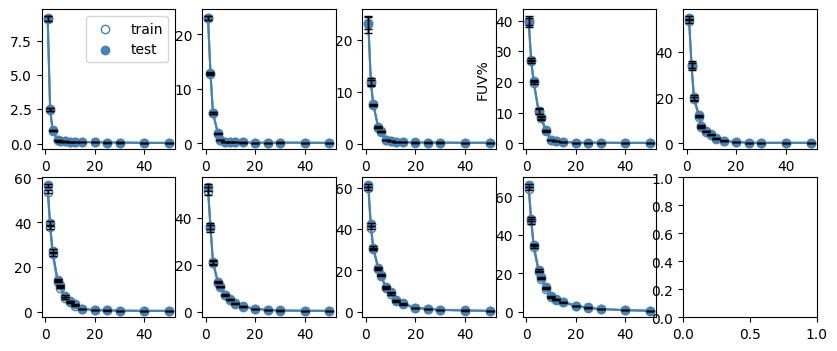

In [17]:
NT=np.arange(2,11,1)
fig,axes=plt.subplots(2,5,figsize=(10,4))
axes=axes.flat
for i,n_target in enumerate(NT):
    ax=axes[i]
    data_train=np.loadtxt(f"./saved_data/bgLV_CDS/I1/reconstruction_T{n_target}_CDS_train.txt")
    data_test=np.loadtxt(f"./saved_data/bgLV_CDS/I1/reconstruction_T{n_target}_CDS_test.txt")
    N_EBD = data_train[0,:]
    for j,data in enumerate([data_train,data_test]):
        FUV = data[1:,:]
        mean_FUV = np.mean(FUV,axis=0)
        std_FUV = np.std(FUV,axis=0,ddof=1)
        se_FUV = std_FUV/np.sqrt(FUV.shape[0])
        mfc = 'white' if j==0 else 'steelblue'
        ax.scatter(N_EBD,mean_FUV,facecolor=mfc,edgecolor='steelblue')
        ax.errorbar(N_EBD,mean_FUV,yerr=se_FUV,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
        ax.plot(N_EBD,mean_FUV,c='steelblue')
ax=axes[0]
ax.scatter([],[],facecolor='white',edgecolor='steelblue',label='train')
ax.scatter([],[],facecolor='steelblue',edgecolor='steelblue',label='test')
ax.legend()
ax=axes[3]
ax.set_xlabel("n$_{embedding}$")
ax.set_ylabel("FUV%")

In [9]:
from scipy.optimize import curve_fit

def y_exp(x,a,b,c):
    yy = -b*(x-a)
    yy[x>a]=0
    y = c*np.exp(yy)
    return y

[5.47110042 1.12213926 0.05927012]
[8.80039221 0.67480756 0.1227538 ]
[11.65451773  0.42334143  0.19695761]
[16.07392239  0.35288128  0.19830053]
[18.57734726  0.27128748  0.33247255]
[18.54014051  0.27290952  0.40505001]
[23.72802952  0.18317184  0.42610714]
[22.48386401  0.19009689  0.8190821 ]
[22.54917979  0.14715429  1.76249375]


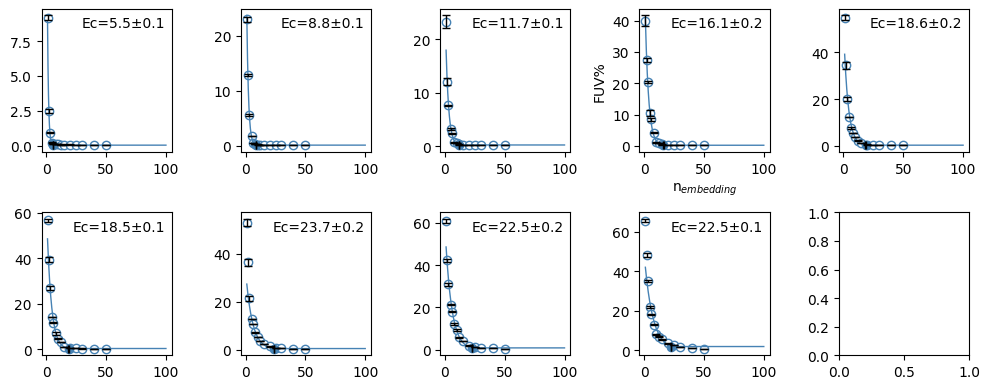

In [14]:
NT=np.arange(2,11,1)
n_trial=5
fig,axes=plt.subplots(2,5,figsize=(10,4))
axes=axes.flat
Ec_data = np.zeros((3,len(NT)))
Ec_data[0,:]=NT
for i,n_target in enumerate(NT):
    ax=axes[i]
    data=np.loadtxt(f"./saved_data/bgLV_CDS/I1/reconstruction_T{n_target}_CDS_test.txt")
    N_EBD=data[0,:]
    FUV = data[1:,:]
    mean_FUV = np.mean(FUV,axis=0)
    std_FUV = np.std(FUV,axis=0,ddof=1)
    se_FUV = std_FUV/np.sqrt(n_trial)
    ax.scatter(N_EBD,mean_FUV,fc='white',ec='steelblue')
    ax.errorbar(N_EBD,mean_FUV,yerr=se_FUV,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
    
    popt, pcov = curve_fit(y_exp, N_EBD, mean_FUV, sigma=se_FUV, absolute_sigma=True, 
                           p0=(10+n_target, 0.2, 0.2))
    print(popt)
    Ec = popt[0]
    param_errors = np.sqrt(np.diag(pcov))# estimate the standard errors of the fitted parameters
    Ec_se = param_errors[0]
    Ec_data[1,i]=Ec
    Ec_data[2,i]=Ec_se
    y_Ec = y_exp(np.array([Ec]),*popt)
    ax.scatter(Ec,y_Ec,c='steelblue')
    ax.errorbar(Ec,y_Ec,xerr=Ec_se,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
    xx=np.linspace(1,100,1000)
    yy=y_exp(xx,*popt)
    ax.plot(xx,yy,color="steelblue",linewidth=1)
    
    ax.text(x=0.95,y=0.95,s="Ec=%1.1f±%1.1f"%(Ec,Ec_se),ha="right",va="top",transform=ax.transAxes)
    if i==3:
        ax.set_xlabel("n$_{embedding}$")
        ax.set_ylabel("FUV%")
fig.tight_layout()
np.savetxt(f"./saved_data/bgLV_CDS/Ec_bgLV_model1_CDS.txt",Ec_data)

Slope            : 2.332 ± 0.012 (SE)
Intercept        : 1.500 ± 0.057 (SE)
t-statistic      : 200.33  (dof = 7)
p-value (slope≠0): 2.04e-14
Weighted R²      : 0.960


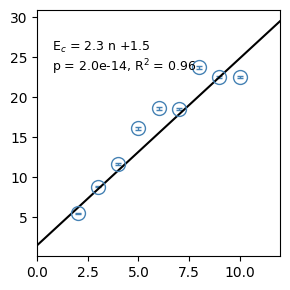

In [31]:
from scipy.optimize import curve_fit
from scipy.stats import t

# Linear model
def linear_model(x, a, b):
    return a * x + b

fig,ax = plt.subplots(1,1,figsize=(3,3))
data = np.loadtxt(f"./saved_data/bgLV_CDS/Ec_bgLV_model1_CDS.txt")
# Extract x, y, and CI bounds
N_TG = data[0,:]
Ec = data[1,:]
Ec_se = data[2,:]
ax.errorbar(N_TG,Ec,Ec_se,marker="o",c='steelblue',mfc="None",capsize=2,lw=0,markersize=10,
                elinewidth=1)

# Weighted fit using standard errors
popt, pcov = curve_fit(linear_model, N_TG, Ec, sigma=Ec_se, absolute_sigma=True)
slope, intercept = popt
slope_se, intercept_se = np.sqrt(np.diag(pcov))

# Compute t-statistic and p-value
dof = len(N_TG) - 2
t_stat = slope / slope_se
p_value = 2 * (1 - t.cdf(np.abs(t_stat), df=dof))

# residuals and total sums of squares
y_pred = linear_model(N_TG, slope, intercept)
SS_res = np.sum(((Ec - y_pred)/Ec_se)**2)     # weighted residual SS
SS_tot = np.sum(((Ec - np.average(Ec, weights=1/Ec_se**2))/Ec_se)**2)

R2 = 1 - SS_res / SS_tot

# Generate fit line and CI band
x_fit = np.linspace(0, 12, 100)
y_fit = linear_model(x_fit, slope, intercept)

ax.plot(x_fit,y_fit,c="k")
ax.set_xlim([0, 12])

# ----- formatted report ---------------------------------------------------
report = (
    f"Slope            : {slope:.3f} ± {slope_se:.3f} (SE)\n"
    f"Intercept        : {intercept:.3f} ± {intercept_se:.3f} (SE)\n"
    f"t-statistic      : {t_stat:.2f}  (dof = {dof})\n"
    f"p-value (slope≠0): {p_value:.3g}\n"
    f"Weighted R²      : {R2:.3f}"
)

print(report)


# Format regression equation
#txt = f"E$_c$ = {slope:.1f} n {'+' if intercept >= 0 else '-'} {abs(intercept):.1f}\np = {p_value:.1e}"
txt = (f"E$_c$ = {slope:.1f} n {intercept:+.1f}\n"
   f"p = {p_value:.1e}, R$^2$ = {R2:.2f}")
ax.text(x=0.06, y=0.75, s=txt, transform=ax.transAxes, fontsize=9)
#ax.text(x=0.11,y=0.85,s=txt,transform=ax.transAxes, fontsize=10)
ax=axes[0]
ax.set_xlabel("observables n", fontsize=13)
ax.set_ylabel("critical dimension E$_c$", fontsize=13)
fig.tight_layout()

## Microbial patches with spatial dimension

In [ ]:
n_ori=100

glv_type="s"
sim_type="fixed"

NT=np.array([2,3,5,9,])
N_EBD=[1,2,3,5,6,8,10,12,15,20]

for i,n_target in enumerate(NT):
    n_background=n_ori-n_target
    for model_index in [1,2,3]:
        data_train = np.zeros((6,len(N_EBD)))
        data_train[0,:] = N_EBD
        data_test = np.zeros((6,len(N_EBD)))
        data_test[0,:] = N_EBD
        X_train, X_test = get_data(n_background, n_target, glv_type, sim_type, model_index)
        batch_train = torch.Tensor(X_train).float()
        batch_test = torch.Tensor(X_test).float()
        for trial in range(1,6,1):
            for j,n_embedding in enumerate(N_EBD):
                model = VAE(n_target,n_embedding)
                model.to("cuda:0");
                model.load_state_dict(
                    torch.load(
                        "./vae_models/%sgLV/I%i/%s_B%i_T%i_E%i_trial%i.pth"
                        % (glv_type, model_index, sim_type, n_background, n_target, n_embedding, trial),weights_only=True)
                )
                mse_train,kld,r2_train=get_error(model,batch_train)
                data_train[trial,j]=(1-r2_train)*100
                mse_test,kld,r2_test=get_error(model,batch_test)
                data_test[trial,j]=(1-r2_test)*100
        np.savetxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_train.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type),data_train)
        np.savetxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_test.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type),data_test)
        print("model %i; target %i finished"%(model_index,n_target,))

Text(0, 0.5, 'FUV%')

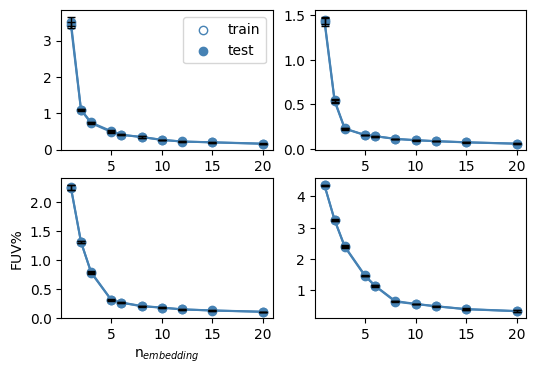

In [18]:
NT=[2,3,5,9,]
n_ori=100
n_trial = 5
glv_type="s"
sim_type="fixed"
model_index=3
fig,axes=plt.subplots(2,2,figsize=(6,4))
axes=axes.flat
for i,n_target in enumerate(NT):
    ax=axes[i]
    n_background = n_ori-n_target
    data_train=np.loadtxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_train.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type))
    data_test=np.loadtxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_test.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type))
    N_EBD = data_train[0,:]
    for j,data in enumerate([data_train,data_test]):
        FUV = data[1:,:]
        mean_FUV = np.mean(FUV,axis=0)
        std_FUV = np.std(FUV,axis=0,ddof=1)
        se_FUV = std_FUV/np.sqrt(n_trial)
        mfc = 'white' if j==0 else 'steelblue'
        ax.scatter(N_EBD,mean_FUV,facecolor=mfc,edgecolor='steelblue')
        ax.errorbar(N_EBD,mean_FUV,yerr=se_FUV,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
        ax.plot(N_EBD,mean_FUV,c='steelblue')
ax=axes[0]
ax.scatter([],[],facecolor='white',edgecolor='steelblue',label='train')
ax.scatter([],[],facecolor='steelblue',edgecolor='steelblue',label='test')
ax.legend()
ax=axes[2]
ax.set_xlabel("n$_{embedding}$")
ax.set_ylabel("FUV%")

In [19]:
from scipy.optimize import curve_fit

def y_exp(x,a,b,c):
    yy = -b*(x-a)
    yy[x>a]=0
    y = c*np.exp(yy)
    return y

[4.30992515 0.67476746 0.24810047]
[4.00652677 0.92734147 0.08770839]
[7.35040042 0.41381922 0.14503754]
[8.85850304 0.27061323 0.51698532]


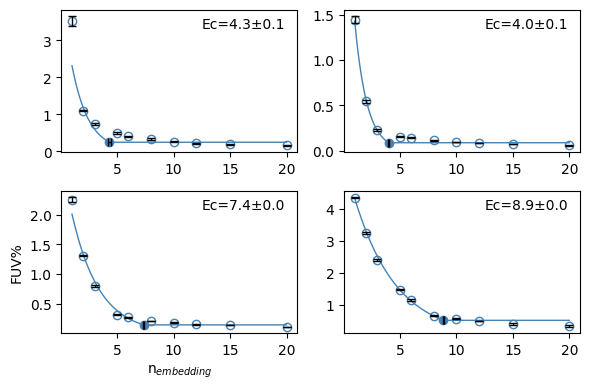

In [22]:
NT=[2,3,5,9,]
n_ori=100
n_trial = 5
glv_type="s"
sim_type="fixed"
model_index=3
fig,axes=plt.subplots(2,2,figsize=(6,4))
axes=axes.flat
Ec_data = np.zeros((3,len(NT)))
Ec_data[0,:]=NT
for i,n_target in enumerate(NT):
    ax=axes[i]
    n_background = n_ori-n_target
    data=np.loadtxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_test.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type))
    N_EBD=data[0,:]
    FUV = data[1:,:]
    mean_FUV = np.mean(FUV,axis=0)
    std_FUV = np.std(FUV,axis=0,ddof=1)
    se_FUV = std_FUV/np.sqrt(n_trial)
    ax.scatter(N_EBD,mean_FUV,fc='white',ec='steelblue')
    ax.errorbar(N_EBD,mean_FUV,yerr=se_FUV,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
    
    popt, pcov = curve_fit(y_exp, N_EBD, mean_FUV, sigma=se_FUV, absolute_sigma=True, p0=(n_target, 0.5, 0.5))
    print(popt)
    Ec = popt[0]
    param_errors = np.sqrt(np.diag(pcov))# estimate the standard errors of the fitted parameters
    Ec_se = param_errors[0]
    Ec_data[1,i]=Ec
    Ec_data[2,i]=Ec_se
    y_Ec = y_exp(np.array([Ec]),*popt)
    ax.scatter(Ec,y_Ec,c='steelblue')
    ax.errorbar(Ec,y_Ec,xerr=Ec_se,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
    xx=np.linspace(1,20,1000)
    yy=y_exp(xx,*popt)
    ax.plot(xx,yy,color="steelblue",linewidth=1)
    
    ax.text(x=0.95,y=0.95,s="Ec=%1.1f±%1.1f"%(Ec,Ec_se),ha="right",va="top",transform=ax.transAxes)
    if i==2:
        ax.set_xlabel("n$_{embedding}$")
        ax.set_ylabel("FUV%")
fig.tight_layout()
np.savetxt(f"./saved_data/{glv_type}gLV/Ec_{glv_type}gLV_model{model_index}_{sim_type}.txt",Ec_data)

fixed sgLV Community 1
Slope            : 0.955 ± 0.013 (SE)
Intercept        : 1.055 ± 0.063 (SE)
t-statistic      : 72.23  (dof = 2)
p-value (slope≠0): 0.000192
Weighted R²      : 0.963
fixed sgLV Community 2
Slope            : 1.280 ± 0.009 (SE)
Intercept        : 0.358 ± 0.049 (SE)
t-statistic      : 137.68  (dof = 2)
p-value (slope≠0): 5.28e-05
Weighted R²      : 0.999
fixed sgLV Community 3
Slope            : 0.685 ± 0.011 (SE)
Intercept        : 3.066 ± 0.068 (SE)
t-statistic      : 62.22  (dof = 2)
p-value (slope≠0): 0.000258
Weighted R²      : 0.822


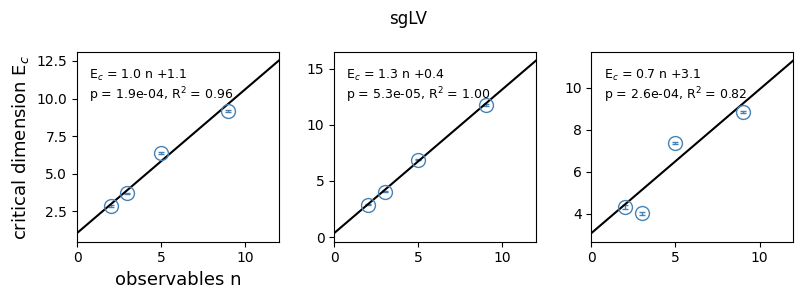

In [5]:
from scipy.optimize import curve_fit
from scipy.stats import t

# Linear model
def linear_model(x, a, b):
    return a * x + b

glv_type="s"
sim_type="fixed"
fig,axes = plt.subplots(1,3,figsize=(8,3))
axes=axes.flat
for i,model_index in enumerate([1,2,3]):
    ax=axes[i]
    data = np.loadtxt(f"./saved_data/{glv_type}gLV/Ec_{glv_type}gLV_model{model_index}_{sim_type}.txt")
    # Extract x, y, and CI bounds
    N_TG = data[0,:]
    Ec = data[1,:]
    Ec_se = data[2,:]
    ax.errorbar(N_TG,Ec,Ec_se,marker="o",c='steelblue',mfc="None",capsize=2,lw=0,markersize=10,
                    elinewidth=1)
    
    # Weighted fit using standard errors
    popt, pcov = curve_fit(linear_model, N_TG, Ec, sigma=Ec_se, absolute_sigma=True)
    slope, intercept = popt
    slope_se, intercept_se = np.sqrt(np.diag(pcov))
    
    # Compute t-statistic and p-value
    dof = len(N_TG) - 2
    t_stat = slope / slope_se
    p_value = 2 * (1 - t.cdf(np.abs(t_stat), df=dof))
    
    # residuals and total sums of squares
    y_pred = linear_model(N_TG, slope, intercept)
    SS_res = np.sum(((Ec - y_pred)/Ec_se)**2)     # weighted residual SS
    SS_tot = np.sum(((Ec - np.average(Ec, weights=1/Ec_se**2))/Ec_se)**2)
    
    R2 = 1 - SS_res / SS_tot
    
    # Generate fit line and CI band
    x_fit = np.linspace(0, 12, 100)
    y_fit = linear_model(x_fit, slope, intercept)

    ax.plot(x_fit,y_fit,c="k")
    ax.set_xlim([0, 12])
    
    # ----- formatted report ---------------------------------------------------
    print(f"{sim_type} {glv_type}gLV Community {model_index}")
    report = (
        f"Slope            : {slope:.3f} ± {slope_se:.3f} (SE)\n"
        f"Intercept        : {intercept:.3f} ± {intercept_se:.3f} (SE)\n"
        f"t-statistic      : {t_stat:.2f}  (dof = {dof})\n"
        f"p-value (slope≠0): {p_value:.3g}\n"
        f"Weighted R²      : {R2:.3f}"
    )

    print(report)

    # Format regression equation
    txt = (f"E$_c$ = {slope:.1f} n {intercept:+.1f}\n"
       f"p = {p_value:.1e}, R$^2$ = {R2:.2f}")
    ax.text(x=0.06, y=0.75, s=txt, transform=ax.transAxes, fontsize=9)
ax=axes[0]
ax.set_xlabel("observables n", fontsize=13)
ax.set_ylabel("critical dimension E$_c$", fontsize=13)
fig.suptitle(f"{glv_type}gLV")
fig.tight_layout()

## Plasmid Dynamics
Plasmid dynamics simulated using the plasmid-centric framework

In [ ]:
n_ori=100
n_background=100
glv_type="p"
sim_type="fixed"

NT=np.array([2,3,4,5,])
N_EBD=[1,2,3,5,6,8,10,12,15,20]
for i,n_target in enumerate(NT):
    for model_index in [1,2,3]:
        data_train = np.zeros((6,len(N_EBD)))
        data_train[0,:] = N_EBD
        data_test = np.zeros((6,len(N_EBD)))
        data_test[0,:] = N_EBD
        X_train, X_test = get_data(n_background, n_target, glv_type, sim_type, model_index)
        batch_train = torch.Tensor(X_train).float()
        batch_test = torch.Tensor(X_test).float()
        for trial in range(1,6,1):
            for j,n_embedding in enumerate(N_EBD):
                model = VAE(n_target,n_embedding)
                model.to("cuda:0");
                model.load_state_dict(
                    torch.load(
                        "./vae_models/%sgLV/I%i/%s_B%i_T%i_E%i_trial%i.pth"
                        % (glv_type, model_index, sim_type, n_background, n_target, n_embedding, trial),weights_only=True)
                )
                mse_train,kld,r2_train=get_error(model,batch_train)
                data_train[trial,j]=(1-r2_train)*100
                mse_test,kld,r2_test=get_error(model,batch_test)
                data_test[trial,j]=(1-r2_test)*100
        np.savetxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_train.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type),data_train)
        np.savetxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_test.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type),data_test)
        print("model %i; target %i finished"%(model_index,n_target,))

Text(0, 0.5, 'FUV%')

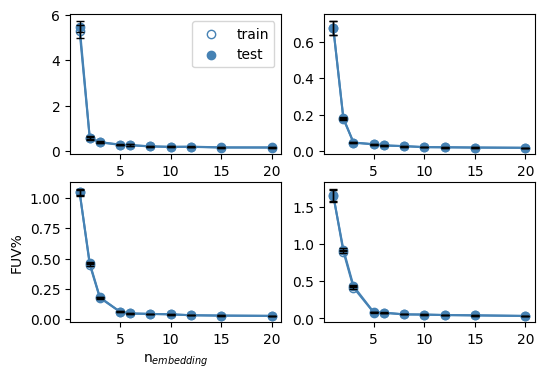

In [25]:
NT=[2,3,4,5,]
n_ori=100
n_trial = 3
n_background = 100
glv_type="p"
sim_type="fixed"
model_index=1
fig,axes=plt.subplots(2,2,figsize=(6,4))
axes=axes.flat
for i,n_target in enumerate(NT):
    ax=axes[i]
    data_train=np.loadtxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_train.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type))
    data_test=np.loadtxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_test.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type))
    N_EBD = data_train[0,:]
    for j,data in enumerate([data_train,data_test]):
        FUV = data[1:,:]
        mean_FUV = np.mean(FUV,axis=0)
        std_FUV = np.std(FUV,axis=0,ddof=1)
        se_FUV = std_FUV/np.sqrt(n_trial)
        mfc = 'white' if j==0 else 'steelblue'
        ax.scatter(N_EBD,mean_FUV,facecolor=mfc,edgecolor='steelblue')
        ax.errorbar(N_EBD,mean_FUV,yerr=se_FUV,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
        ax.plot(N_EBD,mean_FUV,c='steelblue')
ax=axes[0]
ax.scatter([],[],facecolor='white',edgecolor='steelblue',label='train')
ax.scatter([],[],facecolor='steelblue',edgecolor='steelblue',label='test')
ax.legend()
ax=axes[2]
ax.set_xlabel("n$_{embedding}$")
ax.set_ylabel("FUV%")

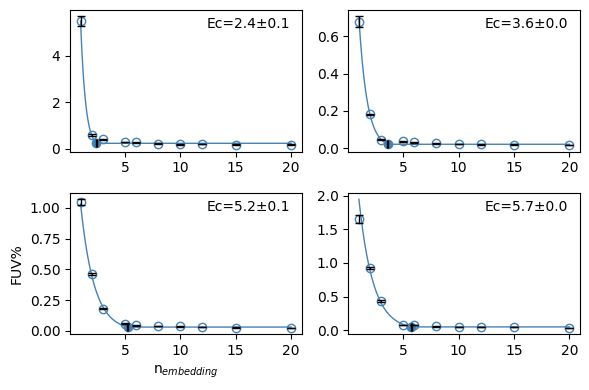

In [53]:
NT=[2,3,4,5,]
n_ori=100
n_background=100
n_trial = 5
glv_type="p"
sim_type="fixed"
model_index=1
fig,axes=plt.subplots(2,2,figsize=(6,4))
axes=axes.flat
Ec_data = np.zeros((3,len(NT)))
Ec_data[0,:]=NT
for i,n_target in enumerate(NT):
    ax=axes[i]
    data=np.loadtxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_test.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type))
    N_EBD=data[0,:]
    FUV = data[1:,:]
    mean_FUV = np.mean(FUV,axis=0)
    std_FUV = np.std(FUV,axis=0,ddof=1)
    se_FUV = std_FUV/np.sqrt(n_trial)
    ax.scatter(N_EBD,mean_FUV,fc='white',ec='steelblue')
    ax.errorbar(N_EBD,mean_FUV,yerr=se_FUV,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
    
    popt, pcov = curve_fit(y_exp, N_EBD, mean_FUV, sigma=se_FUV, absolute_sigma=True, p0=(n_target, 0.5, 0.5))
    Ec = popt[0]
    param_errors = np.sqrt(np.diag(pcov))# estimate the standard errors of the fitted parameters
    Ec_se = param_errors[0]
    Ec_data[1,i]=Ec
    Ec_data[2,i]=Ec_se
    y_Ec = y_exp(np.array([Ec]),*popt)
    ax.scatter(Ec,y_Ec,c='steelblue')
    ax.errorbar(Ec,y_Ec,xerr=Ec_se,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
    xx=np.linspace(1,20,1000)
    yy=y_exp(xx,*popt)
    ax.plot(xx,yy,color="steelblue",linewidth=1)
    
    ax.text(x=0.95,y=0.95,s="Ec=%1.1f±%1.1f"%(Ec,Ec_se),ha="right",va="top",transform=ax.transAxes)
    if i==2:
        ax.set_xlabel("n$_{embedding}$")
        ax.set_ylabel("FUV%")
fig.tight_layout()
np.savetxt(f"./saved_data/{glv_type}gLV/Ec_{glv_type}gLV_model{model_index}_{sim_type}.txt",Ec_data)

fixed pgLV Community 1
Slope            : 1.094 ± 0.018 (SE)
Intercept        : 0.348 ± 0.073 (SE)
t-statistic      : 60.01  (dof = 2)
p-value (slope≠0): 0.000278
Weighted R²      : 0.976
fixed pgLV Community 2
Slope            : 1.228 ± 0.019 (SE)
Intercept        : 0.012 ± 0.061 (SE)
t-statistic      : 63.27  (dof = 2)
p-value (slope≠0): 0.00025
Weighted R²      : 0.972
fixed pgLV Community 3
Slope            : 1.119 ± 0.014 (SE)
Intercept        : 0.353 ± 0.055 (SE)
t-statistic      : 78.67  (dof = 2)
p-value (slope≠0): 0.000162
Weighted R²      : 0.955


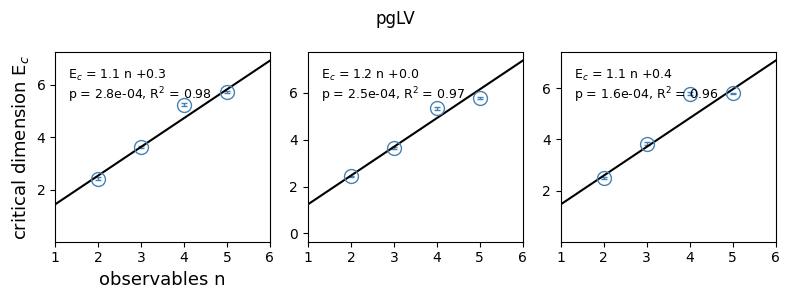

In [6]:
from scipy.optimize import curve_fit
from scipy.stats import t

# Linear model
def linear_model(x, a, b):
    return a * x + b

glv_type="p"
sim_type="fixed"
fig,axes = plt.subplots(1,3,figsize=(8,3))
axes=axes.flat
for i,model_index in enumerate([1,2,3]):
    ax=axes[i]
    data = np.loadtxt(f"./saved_data/{glv_type}gLV/Ec_{glv_type}gLV_model{model_index}_{sim_type}.txt")
    # Extract x, y, and CI bounds
    N_TG = data[0,:]
    Ec = data[1,:]
    Ec_se = data[2,:]
    ax.errorbar(N_TG,Ec,Ec_se,marker="o",c='steelblue',mfc="None",capsize=2,lw=0,markersize=10,
                    elinewidth=1)
    
    # Weighted fit using standard errors
    popt, pcov = curve_fit(linear_model, N_TG, Ec, sigma=Ec_se, absolute_sigma=True)
    slope, intercept = popt
    slope_se, intercept_se = np.sqrt(np.diag(pcov))
    
    # Compute t-statistic and p-value
    dof = len(N_TG) - 2
    t_stat = slope / slope_se
    p_value = 2 * (1 - t.cdf(np.abs(t_stat), df=dof))
        
    # residuals and total sums of squares
    y_pred = linear_model(N_TG, slope, intercept)
    SS_res = np.sum(((Ec - y_pred)/Ec_se)**2)     # weighted residual SS
    SS_tot = np.sum(((Ec - np.average(Ec, weights=1/Ec_se**2))/Ec_se)**2)
    
    R2 = 1 - SS_res / SS_tot
    
    # Generate fit line and CI band
    x_fit = np.linspace(0, 6, 100)
    y_fit = linear_model(x_fit, slope, intercept)

    ax.plot(x_fit,y_fit,c="k")
    ax.set_xlim([1, 6])
    
    # ----- formatted report ---------------------------------------------------
    print(f"{sim_type} {glv_type}gLV Community {model_index}")
    report = (
        f"Slope            : {slope:.3f} ± {slope_se:.3f} (SE)\n"
        f"Intercept        : {intercept:.3f} ± {intercept_se:.3f} (SE)\n"
        f"t-statistic      : {t_stat:.2f}  (dof = {dof})\n"
        f"p-value (slope≠0): {p_value:.3g}\n"
        f"Weighted R²      : {R2:.3f}"
    )

    print(report)

    # Format regression equation
    txt = (f"E$_c$ = {slope:.1f} n {intercept:+.1f}\n"
       f"p = {p_value:.1e}, R$^2$ = {R2:.2f}")
    ax.text(x=0.06, y=0.75, s=txt, transform=ax.transAxes, fontsize=9)
ax=axes[0]
ax.set_xlabel("observables n", fontsize=13)
ax.set_ylabel("critical dimension E$_c$", fontsize=13)
fig.suptitle(f"{glv_type}gLV")
fig.tight_layout()

## gLV model with dispersal

### Fixed background case

In [ ]:
n_ori=100

glv_type="d"
sim_type="fixed"

NT=np.arange(2,9,1)
N_EBD = [1, 2, 3, 5, 6, 8, 10, 12, 15, 20]
for i,n_target in enumerate(NT):
    n_background=n_ori-n_target
    for model_index in [1,2,3]:
        data_train = np.zeros((6,len(N_EBD)))
        data_train[0,:] = N_EBD
        data_test = np.zeros((6,len(N_EBD)))
        data_test[0,:] = N_EBD
        X_train, X_test = get_data(n_background, n_target, glv_type, sim_type, model_index)
        batch_train = torch.Tensor(X_train).float()
        batch_test = torch.Tensor(X_test).float()
        for trial in range(1,6,1):
            for j,n_embedding in enumerate(N_EBD):
                model = VAE4(n_target,n_embedding)
                model.to("cuda:0");
                model.load_state_dict(
                    torch.load(
                        "./vae_models/%sgLV/I%i/%s_B%i_T%i_E%i_trial%i.pth"
                        % (glv_type, model_index, sim_type, n_background, n_target, n_embedding, trial),weights_only=True)
                )
                mse_train,kld,r2_train=get_error(model,batch_train)
                data_train[trial,j]=(1-r2_train)*100
                mse_test,kld,r2_test=get_error(model,batch_test)
                data_test[trial,j]=(1-r2_test)*100
        np.savetxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_train.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type),data_train)
        np.savetxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_test.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type),data_test)
        print("model %i; target %i finished"%(model_index,n_target,))

In [ ]:
NT=np.arange(2,9,1)
n_ori=100
n_trial = 5
glv_type="d"
sim_type="fixed"
model_index=3
fig,axes=plt.subplots(2,4,figsize=(8,4))
axes=axes.flat
for i,n_target in enumerate(NT):
    ax=axes[i]
    n_background = n_ori-n_target
    data_train=np.loadtxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_train.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type))
    data_test=np.loadtxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_test.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type))
    N_EBD = data_train[0,:]
    for j,data in enumerate([data_train,data_test]):
        FUV = data[1:,:]
        mean_FUV = np.mean(FUV,axis=0)
        std_FUV = np.std(FUV,axis=0,ddof=1)
        se_FUV = std_FUV/np.sqrt(n_trial)
        mfc = 'white' if j==0 else 'steelblue'
        ax.scatter(N_EBD,mean_FUV,facecolor=mfc,edgecolor='steelblue')
        ax.errorbar(N_EBD,mean_FUV,yerr=se_FUV,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
        ax.plot(N_EBD,mean_FUV,c='steelblue')
ax=axes[0]
ax.scatter([],[],facecolor='white',edgecolor='steelblue',label='train')
ax.scatter([],[],facecolor='steelblue',edgecolor='steelblue',label='test')
ax.legend()
ax=axes[2]
ax.set_xlabel("n$_{embedding}$")
ax.set_ylabel("FUV%")

In [10]:
from scipy.optimize import curve_fit

def y_exp(x,a,b,c):
    yy = -b*(x-a)
    yy[x>a]=0
    y = c*np.exp(yy)
    return y

[2.49813954 1.99085861 0.23207459]
[3.38483518 1.08942306 0.2126663 ]
[4.07435969 0.71570035 0.4829111 ]
[6.05962913 0.37013507 0.62815742]
[7.16893173 0.30078145 0.54081904]
[7.27910513 0.27855588 0.6984851 ]
[6.74235579 0.32054582 0.78303986]


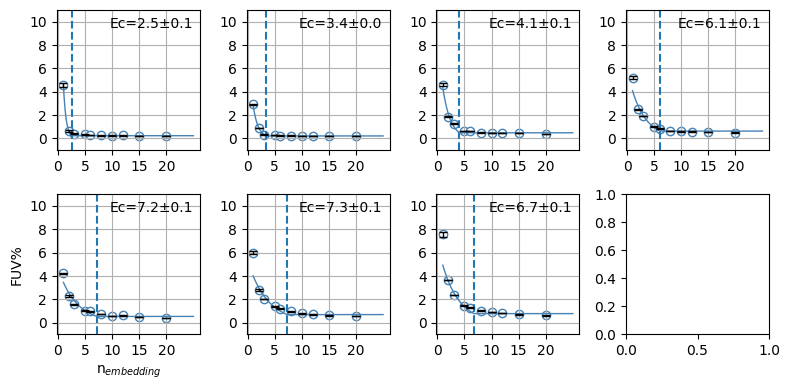

In [40]:
NT=np.arange(2,9,1)
n_ori=100
n_trial = 5
glv_type="d"
sim_type="fixed"
model_index=1
fig,axes=plt.subplots(2,4,figsize=(8,4))
axes=axes.flat
Ec_data = np.zeros((3,len(NT)))
Ec_data[0,:]=NT
for i,n_target in enumerate(NT):
    ax=axes[i]
    n_background = n_ori-n_target
    data=np.loadtxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_test.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type))
    N_EBD=data[0,:]
    FUV = data[1:,:]
    mean_FUV = np.mean(FUV,axis=0)
    std_FUV = np.std(FUV,axis=0,ddof=1)
    se_FUV = std_FUV/np.sqrt(n_trial)
    ax.scatter(N_EBD,mean_FUV,fc='white',ec='steelblue')
    ax.errorbar(N_EBD,mean_FUV,yerr=se_FUV,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
    
    popt, pcov = curve_fit(y_exp, N_EBD, mean_FUV, sigma=se_FUV, absolute_sigma=True, p0=(n_target-1, 0.5, 0.5))
    print(popt)
    Ec = popt[0]
    param_errors = np.sqrt(np.diag(pcov))# estimate the standard errors of the fitted parameters
    Ec_se = param_errors[0]
    Ec_data[1,i]=Ec
    Ec_data[2,i]=Ec_se
    y_Ec = y_exp(np.array([Ec]),*popt)
    ax.plot([Ec,Ec],[-1,100],ls="--")
    xx=np.linspace(1,25,1000)
    yy=y_exp(xx,*popt)
    ax.plot(xx,yy,color="steelblue",linewidth=1)
    
    ax.text(x=0.95,y=0.95,s="Ec=%1.1f±%1.1f"%(Ec,Ec_se),ha="right",va="top",transform=ax.transAxes)
    if i==4:
        ax.set_xlabel("n$_{embedding}$")
        ax.set_ylabel("FUV%")

    ax.set_xticks(np.arange(0,25,5))
    ax.set_yticks([0,2,4,6,8,10])
    ax.set_ylim([-1,11])
    ax.grid(True)
fig.tight_layout()
np.savetxt(f"./saved_data/{glv_type}gLV/Ec_{glv_type}gLV_model{model_index}_{sim_type}.txt",Ec_data)

fixed dgLV Community 1
Slope            : 0.832 ± 0.012 (SE)
Intercept        : 0.974 ± 0.054 (SE)
t-statistic      : 69.05  (dof = 5)
p-value (slope≠0): 1.21e-08
Weighted R²      : 0.897
fixed dgLV Community 2
Slope            : 0.861 ± 0.009 (SE)
Intercept        : 1.023 ± 0.055 (SE)
t-statistic      : 92.06  (dof = 5)
p-value (slope≠0): 2.87e-09
Weighted R²      : 0.948
fixed dgLV Community 3
Slope            : 0.537 ± 0.018 (SE)
Intercept        : 1.390 ± 0.082 (SE)
t-statistic      : 30.64  (dof = 5)
p-value (slope≠0): 6.95e-07
Weighted R²      : 0.819


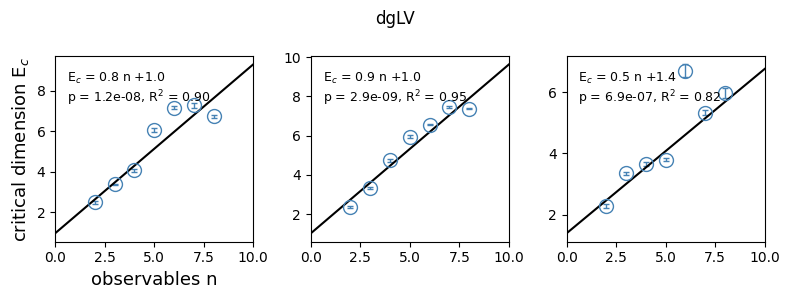

In [42]:
from scipy.optimize import curve_fit
from scipy.stats import t

# Linear model
def linear_model(x, a, b):
    return a * x + b

glv_type="d"
sim_type="fixed"
fig,axes = plt.subplots(1,3,figsize=(8,3))
axes=axes.flat
for i,model_index in enumerate([1,2,3]):
    ax=axes[i]
    data = np.loadtxt(f"./saved_data/{glv_type}gLV/Ec_{glv_type}gLV_model{model_index}_{sim_type}.txt")
    # Extract x, y, and CI bounds
    N_TG = data[0,:]
    Ec = data[1,:]
    Ec_se = data[2,:]
    ax.errorbar(N_TG,Ec,Ec_se,marker="o",c='steelblue',mfc="None",capsize=2,lw=0,markersize=10,
                    elinewidth=1)
    
    # Weighted fit using standard errors
    popt, pcov = curve_fit(linear_model, N_TG, Ec, sigma=Ec_se, absolute_sigma=True)
    slope, intercept = popt
    slope_se, intercept_se = np.sqrt(np.diag(pcov))
    
    # Compute t-statistic and p-value
    dof = len(N_TG) - 2
    t_stat = slope / slope_se
    p_value = 2 * (1 - t.cdf(np.abs(t_stat), df=dof))

    # residuals and total sums of squares
    y_pred = linear_model(N_TG, slope, intercept)
    SS_res = np.sum(((Ec - y_pred)/Ec_se)**2)     # weighted residual SS
    SS_tot = np.sum(((Ec - np.average(Ec, weights=1/Ec_se**2))/Ec_se)**2)
    
    R2 = 1 - SS_res / SS_tot

    # ----- formatted report ---------------------------------------------------
    print(f"{sim_type} {glv_type}gLV Community {model_index}")
    report = (
        f"Slope            : {slope:.3f} ± {slope_se:.3f} (SE)\n"
        f"Intercept        : {intercept:.3f} ± {intercept_se:.3f} (SE)\n"
        f"t-statistic      : {t_stat:.2f}  (dof = {dof})\n"
        f"p-value (slope≠0): {p_value:.3g}\n"
        f"Weighted R²      : {R2:.3f}"
    )

    print(report)
    
    # Generate fit line and CI band
    x_fit = np.linspace(0, 10, 100)
    y_fit = linear_model(x_fit, slope, intercept)
    ax.plot(x_fit,y_fit,c="k")
    ax.set_xlim([0, 10])
    
    # Format regression equation
    txt = (f"E$_c$ = {slope:.1f} n {intercept:+.1f}\n"
       f"p = {p_value:.1e}, R$^2$ = {R2:.2f}")
    ax.text(x=0.06, y=0.75, s=txt, transform=ax.transAxes, fontsize=9)
ax=axes[0]
ax.set_xlabel("observables n", fontsize=13)
ax.set_ylabel("critical dimension E$_c$", fontsize=13)
fig.suptitle(f"{glv_type}gLV")
fig.tight_layout()

### random background case

In [ ]:
n_ori=100

glv_type="d"
sim_type="random"

NT=np.arange(1,9,1)
N_EBD = [3, 5, 8, 10, 12, 15, 20, 25, 30, 40, 50, 60, 80]
for i,n_target in enumerate(NT):
    n_background=n_ori-n_target
    for model_index in [1,2,3]:
        data_train = np.zeros((6,len(N_EBD)))
        data_train[0,:] = N_EBD
        data_test = np.zeros((6,len(N_EBD)))
        data_test[0,:] = N_EBD
        X_train, X_test = get_data(n_background, n_target, glv_type, sim_type, model_index)
        batch_train = torch.Tensor(X_train).float()
        batch_test = torch.Tensor(X_test).float()
        for trial in range(1,6,1):
            for j,n_embedding in enumerate(N_EBD):
                model = VAE(n_target,n_embedding)
                model.to("cuda:0");
                model.load_state_dict(
                    torch.load(
                        "./vae_models/%sgLV/I%i/%s_B%i_T%i_E%i_trial%i.pth"
                        % (glv_type, model_index, sim_type, n_background, n_target, n_embedding, trial),weights_only=True)
                )
                mse_train,kld,r2_train=get_error(model,batch_train)
                data_train[trial,j]=(1-r2_train)*100
                mse_test,kld,r2_test=get_error(model,batch_test)
                data_test[trial,j]=(1-r2_test)*100
        np.savetxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_train.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type),data_train)
        np.savetxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_test.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type),data_test)
        print("model %i; target %i finished"%(model_index,n_target,))

Text(0, 0.5, 'FUV%')

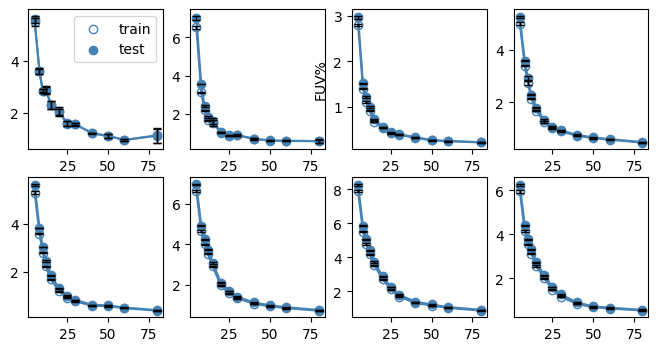

In [55]:
NT=np.arange(1,9,1)
n_ori=100
n_trial = 5
glv_type="d"
sim_type="random"
model_index=1
fig,axes=plt.subplots(2,4,figsize=(8,4))
axes=axes.flat
for i,n_target in enumerate(NT):
    ax=axes[i]
    n_background = n_ori-n_target
    data_train=np.loadtxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_train.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type))[:,1:]
    data_test=np.loadtxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_test.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type))[:,1:]
    N_EBD = data_train[0,:]
    for j,data in enumerate([data_train,data_test]):
        FUV = data[1:,:]
        mean_FUV = np.mean(FUV,axis=0)
        std_FUV = np.std(FUV,axis=0,ddof=1)
        se_FUV = std_FUV/np.sqrt(n_trial)
        mfc = 'white' if j==0 else 'steelblue'
        ax.scatter(N_EBD,mean_FUV,facecolor=mfc,edgecolor='steelblue')
        ax.errorbar(N_EBD,mean_FUV,yerr=se_FUV,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
        ax.plot(N_EBD,mean_FUV,c='steelblue')
ax=axes[0]
ax.scatter([],[],facecolor='white',edgecolor='steelblue',label='train')
ax.scatter([],[],facecolor='steelblue',edgecolor='steelblue',label='test')
ax.legend()
ax=axes[2]
ax.set_xlabel("n$_{embedding}$")
ax.set_ylabel("FUV%")

In [56]:
from scipy.optimize import curve_fit

def y_exp(x,a,b,c):
    yy = -b*(x-a)
    yy[x>a]=0
    y = c*np.exp(yy)
    return y

[13.41720897  0.31968232  0.29380821]
[13.85332634  0.28927903  0.37192385]
[18.33736618  0.22058391  0.51712476]
[22.25192767  0.14070952  1.0961057 ]
[29.53328885  0.11493098  0.53447081]
[26.61472361  0.10238828  1.06667456]
[22.45964577  0.12932965  1.25963765]
[29.74285825  0.09972317  0.87224455]


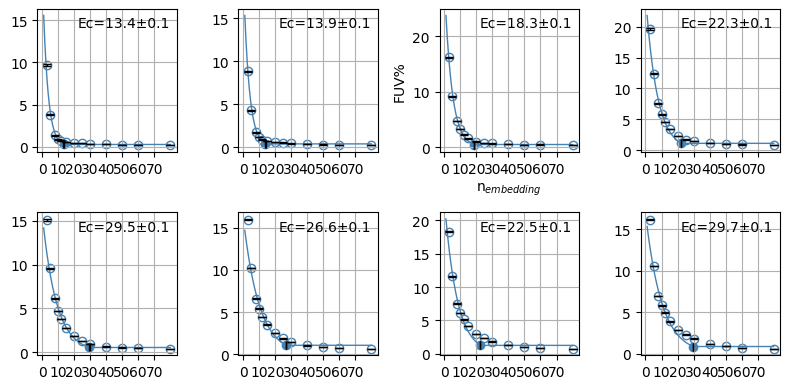

In [59]:
NT=np.arange(1,9,1)
n_ori=100
n_trial = 5
glv_type="d"
sim_type="random"
model_index=3
fig,axes=plt.subplots(2,4,figsize=(8,4))
axes=axes.flat
Ec_data = np.zeros((3,len(NT)))
Ec_data[0,:]=NT
for i,n_target in enumerate(NT):
    ax=axes[i]
    n_background = n_ori-n_target
    data=np.loadtxt("./saved_data/%sgLV/I%i/reconstruction_B%i_T%i_%sgLV_%s_test.txt"%
                   (glv_type,model_index,n_background,n_target,glv_type,sim_type))
    N_EBD=data[0,:]
    FUV = data[1:,:]
    mean_FUV = np.mean(FUV,axis=0)
    std_FUV = np.std(FUV,axis=0,ddof=1)
    se_FUV = std_FUV/np.sqrt(n_trial)
    ax.scatter(N_EBD,mean_FUV,fc='white',ec='steelblue')
    ax.errorbar(N_EBD,mean_FUV,yerr=se_FUV,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
    
    popt, pcov = curve_fit(y_exp, N_EBD, mean_FUV, sigma=se_FUV, absolute_sigma=True, p0=(5*n_target, 0.2, 1))
    print(popt)
    Ec = popt[0]
    param_errors = np.sqrt(np.diag(pcov))# estimate the standard errors of the fitted parameters
    Ec_se = param_errors[0]
    Ec_data[1,i]=Ec
    Ec_data[2,i]=Ec_se
    y_Ec = y_exp(np.array([Ec]),*popt)
    ax.scatter(Ec,y_Ec,c='steelblue')
    ax.errorbar(Ec,y_Ec,xerr=Ec_se,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
    xx=np.linspace(1,80,1000)
    yy=y_exp(xx,*popt)
    ax.plot(xx,yy,color="steelblue",linewidth=1)
    
    ax.text(x=0.95,y=0.95,s="Ec=%1.1f±%1.1f"%(Ec,Ec_se),ha="right",va="top",transform=ax.transAxes)
    if i==2:
        ax.set_xlabel("n$_{embedding}$")
        ax.set_ylabel("FUV%")
    ax.set_xticks(np.arange(0,80,10))
    #ax.set_yticks([0,2,4,6,8,10])
    #ax.set_ylim([0,10])
    ax.grid(True)
fig.tight_layout()
np.savetxt(f"./saved_data/{glv_type}gLV/Ec_{glv_type}gLV_model{model_index}_{sim_type}.txt",Ec_data)

random dgLV Community 1
Slope            : 3.568 ± 0.023 (SE)
Intercept        : 7.565 ± 0.108 (SE)
t-statistic      : 154.54  (dof = 6)
p-value (slope≠0): 4.95e-12
Weighted R²      : 0.958
random dgLV Community 2
Slope            : 4.017 ± 0.013 (SE)
Intercept        : 9.902 ± 0.049 (SE)
t-statistic      : 301.79  (dof = 6)
p-value (slope≠0): 8.93e-14
Weighted R²      : 0.978
random dgLV Community 3
Slope            : 2.243 ± 0.011 (SE)
Intercept        : 11.245 ± 0.050 (SE)
t-statistic      : 198.33  (dof = 6)
p-value (slope≠0): 1.11e-12
Weighted R²      : 0.790


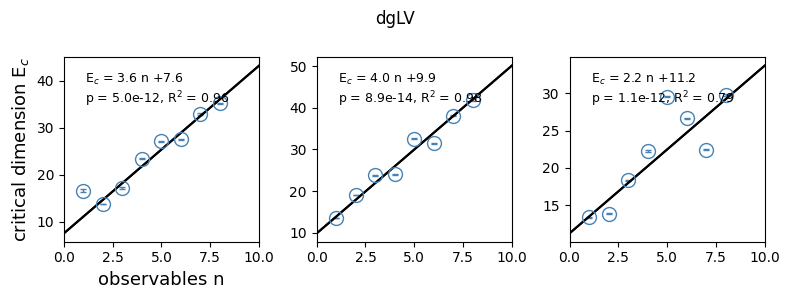

In [61]:
from scipy.optimize import curve_fit
from scipy.stats import t

# Linear model
def linear_model(x, a, b):
    return a * x + b

glv_type="d"
sim_type="random"
fig,axes = plt.subplots(1,3,figsize=(8,3))
axes=axes.flat
for i,model_index in enumerate([1,2,3]):
    ax=axes[i]
    data = np.loadtxt(f"./saved_data/{glv_type}gLV/Ec_{glv_type}gLV_model{model_index}_{sim_type}.txt")
    # Extract x, y, and CI bounds
    N_TG = data[0,:]
    Ec = data[1,:]
    Ec_se = data[2,:]
    ax.errorbar(N_TG,Ec,Ec_se,marker="o",c='steelblue',mfc="None",capsize=2,lw=0,markersize=10,
                    elinewidth=1)
    
    # Weighted fit using standard errors
    popt, pcov = curve_fit(linear_model, N_TG, Ec, sigma=Ec_se, absolute_sigma=True)
    slope, intercept = popt
    slope_se, intercept_se = np.sqrt(np.diag(pcov))
    
    # Compute t-statistic and p-value
    dof = len(N_TG) - 2
    t_stat = slope / slope_se
    p_value = 2 * (1 - t.cdf(np.abs(t_stat), df=dof))
    
    # Generate fit line and CI band
    x_fit = np.linspace(0, 10, 100)
    y_fit = linear_model(x_fit, slope, intercept)
    ax.plot(x_fit,y_fit,c="k")
    ax.set_xlim([0, 10])
    
    # residuals and total sums of squares
    y_pred = linear_model(N_TG, slope, intercept)
    SS_res = np.sum(((Ec - y_pred)/Ec_se)**2)     # weighted residual SS
    SS_tot = np.sum(((Ec - np.average(Ec, weights=1/Ec_se**2))/Ec_se)**2)
    
    R2 = 1 - SS_res / SS_tot

    # ----- formatted report ---------------------------------------------------
    print(f"{sim_type} {glv_type}gLV Community {model_index}")
    report = (
        f"Slope            : {slope:.3f} ± {slope_se:.3f} (SE)\n"
        f"Intercept        : {intercept:.3f} ± {intercept_se:.3f} (SE)\n"
        f"t-statistic      : {t_stat:.2f}  (dof = {dof})\n"
        f"p-value (slope≠0): {p_value:.3g}\n"
        f"Weighted R²      : {R2:.3f}"
    )

    print(report)
    
    # Generate fit line and CI band
    x_fit = np.linspace(0, 10, 100)
    y_fit = linear_model(x_fit, slope, intercept)
    ax.plot(x_fit,y_fit,c="k")
    ax.set_xlim([0, 10])
    
    # Format regression equation
    txt = (f"E$_c$ = {slope:.1f} n {intercept:+.1f}\n"
       f"p = {p_value:.1e}, R$^2$ = {R2:.2f}")
    ax.text(x=0.11, y=0.75, s=txt, transform=ax.transAxes, fontsize=9)
    #ax.text(x=0.11,y=0.85,s=txt,transform=ax.transAxes, fontsize=10)
ax=axes[0]
ax.set_xlabel("observables n", fontsize=13)
ax.set_ylabel("critical dimension E$_c$", fontsize=13)
fig.suptitle(f"{glv_type}gLV")
fig.tight_layout()